[1편. 이상탐지 너 뭐야?](https://dacon.io/codeshare/4758)  
[2편. 신용카드 사기 탐지(1부)](https://dacon.io/codeshare/4833)  
[3편. 신용카드 사기 탐지(2부)](https://dacon.io/codeshare/4853)  
[4편. 비지도 학습 기반의 머신러닝 기법(1부)](https://dacon.io/codeshare/4874)  
[5편. 비지도 학습 기반의 머신러닝 기법(2부)](https://dacon.io/codeshare/4890)  
[6편. 비지도 학습 기반의 머신러닝 기법을 활용한 이상탐지(1부)](https://dacon.io/codeshare/4954)    
[7편. 비지도 학습 기반의 머신러닝 기법을 활용한 이상탐지(2부)](https://dacon.io/codeshare/5000)  
[8편. 오토인코더 개념](https://dacon.io/codeshare/5064)  
[9편. 오토인코더 실습(1부)](https://dacon.io/codeshare/5104)

# 6.8 선형 활성화 함수와 드롭아웃으로 구성된 과대완전 오토인코더

- 드롭아웃 : 과대 적합을 줄이기 위해 정규화 기술을 사용 하는 것
- 오토인코더가 신경망 계층의 유닛을 사전에 정의한 비율만큼 제외시킴
- 데이터 셋의 특징을 더 많이학습하고 중요하지 않은 정보는 버림
- 드롭아웃 비율 : 10%(뉴런의 10%제외)
  - 드롭아웃 비율이 높을수록 정규화가 강해짐

In [ ]:
## 라이브러리 불러오기
'''메인 라이브러리'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip

'''시각화 관련 라이브러리'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''데이터 준비 및 모델 평가 관련 라이브러리'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

'''알고리즘 관련 라이브러리'''
import lightgbm as lgb

'''텐서플로 및 케라스 관련 라이브러리'''
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from keras.layers import BatchNormalization, Input, Lambda
from keras import regularizers
from keras.losses import mse, binary_crossentropy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 데이터 로드
current_path = os.getcwd()
data = pd.read_csv('/content/drive/MyDrive/데이콘_이상탐지/datasets/credit_card_data/credit_card.csv')

In [ ]:
dataX = data.copy().drop(['Class','Time'],axis=1)

In [ ]:
dataY = data['Class'].copy()

In [ ]:
# 데이터 스케일

In [ ]:
featuresToScale = dataX.columns

In [ ]:
sX = pp.StandardScaler(copy=True, with_mean=True, with_std=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])

In [ ]:
# 훈련 및 테스트 셋으로 분할 

In [ ]:
X_train, X_test, y_train, y_test = \
    train_test_split(dataX, dataY, test_size=0.33, \
                     random_state=2018, stratify=dataY)

In [ ]:
X_train_AE = X_train.copy()
X_test_AE = X_test.copy()

In [ ]:
# 평가 함수(이상치 스코어 함수) 및 그래프 함수 정의

In [ ]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF) - \
                   np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

In [ ]:
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'], \
                               preds['anomalyScore'])
    average_precision = average_precision_score( \
                        preds['trueLabel'], preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = \
        {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], \
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: Area under the \
        curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds, average_precision  ### diff

## 모델링

Epoch 1/10
5964/5964 [==============================] - 28s 4ms/step - loss: 0.1277 - accuracy: 0.7497 - val_loss: 0.0109 - val_accuracy: 0.9678
Epoch 2/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0770 - accuracy: 0.7866 - val_loss: 0.0076 - val_accuracy: 0.9768
Epoch 3/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0770 - accuracy: 0.7883 - val_loss: 0.0072 - val_accuracy: 0.9766
Epoch 4/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0762 - accuracy: 0.7869 - val_loss: 0.0118 - val_accuracy: 0.9647
Epoch 5/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0760 - accuracy: 0.7872 - val_loss: 0.0105 - val_accuracy: 0.9646
Epoch 6/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0770 - accuracy: 0.7868 - val_loss: 0.0082 - val_accuracy: 0.9715
Epoch 7/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0766 - accuracy: 0.7861 - val_loss: 0.0071 - val_ac

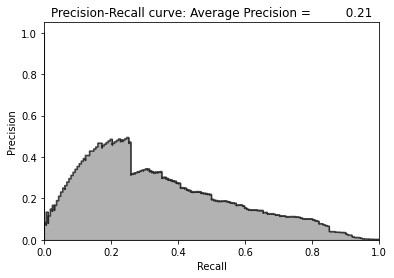

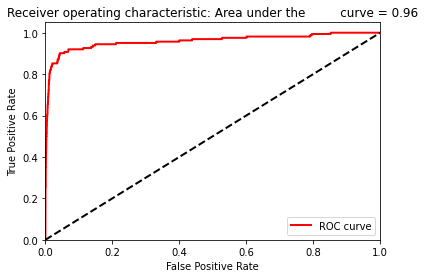

Epoch 1/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.1316 - accuracy: 0.7467 - val_loss: 0.0075 - val_accuracy: 0.9757
Epoch 2/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0773 - accuracy: 0.7869 - val_loss: 0.0072 - val_accuracy: 0.9802
Epoch 3/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0772 - accuracy: 0.7878 - val_loss: 0.0077 - val_accuracy: 0.9780
Epoch 4/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0760 - accuracy: 0.7857 - val_loss: 0.0072 - val_accuracy: 0.9770
Epoch 5/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0762 - accuracy: 0.7883 - val_loss: 0.0101 - val_accuracy: 0.9674
Epoch 6/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0766 - accuracy: 0.7881 - val_loss: 0.0081 - val_accuracy: 0.9708
Epoch 7/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0755 - accuracy: 0.7882 - val_loss: 0.0087 - val_ac

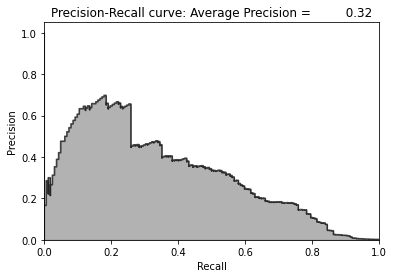

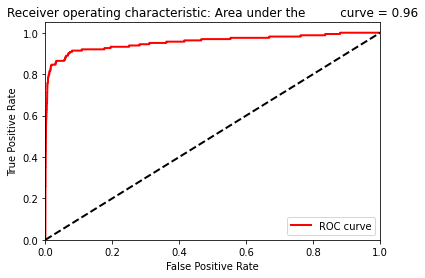

Epoch 1/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.1370 - accuracy: 0.7388 - val_loss: 0.0082 - val_accuracy: 0.9739
Epoch 2/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0760 - accuracy: 0.7861 - val_loss: 0.0078 - val_accuracy: 0.9738
Epoch 3/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0768 - accuracy: 0.7875 - val_loss: 0.0073 - val_accuracy: 0.9758
Epoch 4/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0783 - accuracy: 0.7862 - val_loss: 0.0067 - val_accuracy: 0.9796
Epoch 5/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0774 - accuracy: 0.7854 - val_loss: 0.0072 - val_accuracy: 0.9784
Epoch 6/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0762 - accuracy: 0.7854 - val_loss: 0.0106 - val_accuracy: 0.9677
Epoch 7/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0768 - accuracy: 0.7852 - val_loss: 0.0092 - val_ac

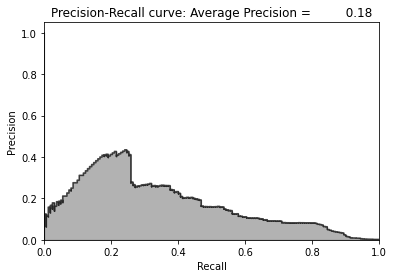

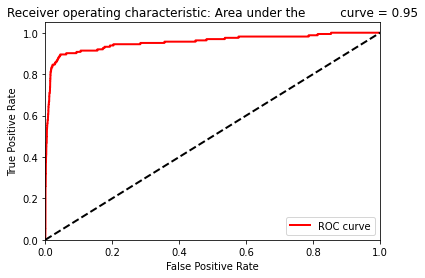

Epoch 1/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.1297 - accuracy: 0.7437 - val_loss: 0.0090 - val_accuracy: 0.9729
Epoch 2/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0760 - accuracy: 0.7858 - val_loss: 0.0067 - val_accuracy: 0.9781
Epoch 3/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0757 - accuracy: 0.7851 - val_loss: 0.0089 - val_accuracy: 0.9752
Epoch 4/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0746 - accuracy: 0.7855 - val_loss: 0.0065 - val_accuracy: 0.9773
Epoch 5/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0786 - accuracy: 0.7861 - val_loss: 0.0068 - val_accuracy: 0.9773
Epoch 6/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0773 - accuracy: 0.7855 - val_loss: 0.0109 - val_accuracy: 0.9609
Epoch 7/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0768 - accuracy: 0.7836 - val_loss: 0.0077 - val_ac

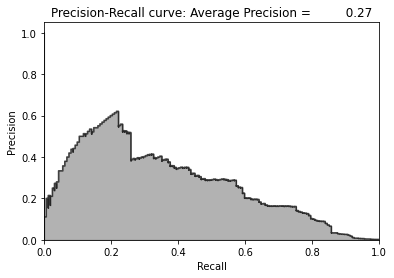

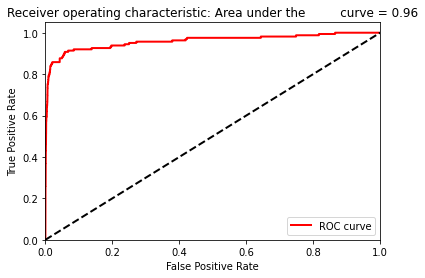

Epoch 1/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.1380 - accuracy: 0.7389 - val_loss: 0.0088 - val_accuracy: 0.9736
Epoch 2/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0773 - accuracy: 0.7865 - val_loss: 0.0087 - val_accuracy: 0.9710
Epoch 3/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0767 - accuracy: 0.7858 - val_loss: 0.0079 - val_accuracy: 0.9752
Epoch 4/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0766 - accuracy: 0.7870 - val_loss: 0.0074 - val_accuracy: 0.9748
Epoch 5/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0760 - accuracy: 0.7864 - val_loss: 0.0092 - val_accuracy: 0.9696
Epoch 6/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0766 - accuracy: 0.7856 - val_loss: 0.0071 - val_accuracy: 0.9769
Epoch 7/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0784 - accuracy: 0.7866 - val_loss: 0.0079 - val_ac

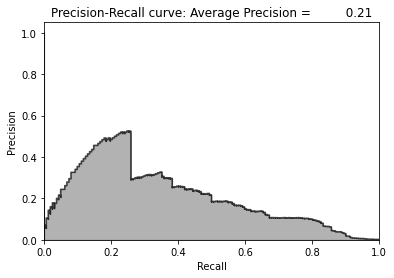

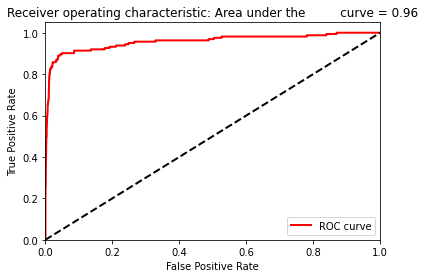

Epoch 1/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.1354 - accuracy: 0.7395 - val_loss: 0.0098 - val_accuracy: 0.9713
Epoch 2/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0765 - accuracy: 0.7858 - val_loss: 0.0074 - val_accuracy: 0.9755
Epoch 3/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0774 - accuracy: 0.7848 - val_loss: 0.0112 - val_accuracy: 0.9685
Epoch 4/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0759 - accuracy: 0.7870 - val_loss: 0.0077 - val_accuracy: 0.9764
Epoch 5/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0764 - accuracy: 0.7878 - val_loss: 0.0071 - val_accuracy: 0.9788
Epoch 6/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0763 - accuracy: 0.7862 - val_loss: 0.0069 - val_accuracy: 0.9753
Epoch 7/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0770 - accuracy: 0.7867 - val_loss: 0.0134 - val_ac

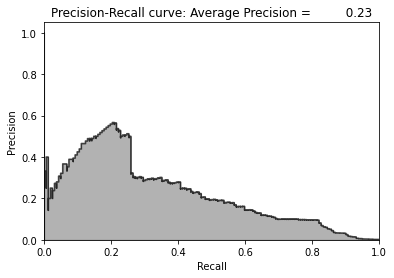

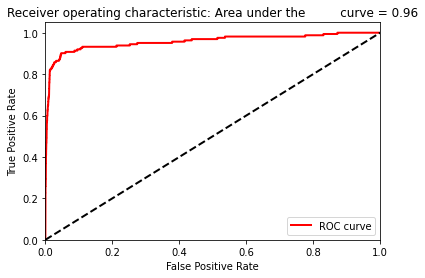

Epoch 1/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.1349 - accuracy: 0.7388 - val_loss: 0.0093 - val_accuracy: 0.9736
Epoch 2/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0775 - accuracy: 0.7832 - val_loss: 0.0075 - val_accuracy: 0.9747
Epoch 3/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0766 - accuracy: 0.7856 - val_loss: 0.0075 - val_accuracy: 0.9783
Epoch 4/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0766 - accuracy: 0.7845 - val_loss: 0.0073 - val_accuracy: 0.9755
Epoch 5/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0757 - accuracy: 0.7850 - val_loss: 0.0079 - val_accuracy: 0.9692
Epoch 6/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0774 - accuracy: 0.7840 - val_loss: 0.0073 - val_accuracy: 0.9751
Epoch 7/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0771 - accuracy: 0.7845 - val_loss: 0.0069 - val_ac

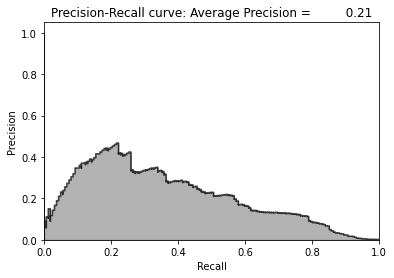

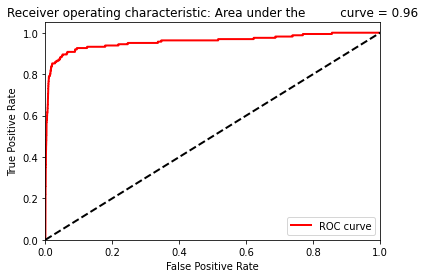

Epoch 1/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.1346 - accuracy: 0.7403 - val_loss: 0.0078 - val_accuracy: 0.9740
Epoch 2/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0781 - accuracy: 0.7843 - val_loss: 0.0109 - val_accuracy: 0.9682
Epoch 3/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0770 - accuracy: 0.7862 - val_loss: 0.0073 - val_accuracy: 0.9756
Epoch 4/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0761 - accuracy: 0.7847 - val_loss: 0.0079 - val_accuracy: 0.9738
Epoch 5/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0768 - accuracy: 0.7860 - val_loss: 0.0084 - val_accuracy: 0.9720
Epoch 6/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0769 - accuracy: 0.7862 - val_loss: 0.0082 - val_accuracy: 0.9747
Epoch 7/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0771 - accuracy: 0.7877 - val_loss: 0.0070 - val_ac

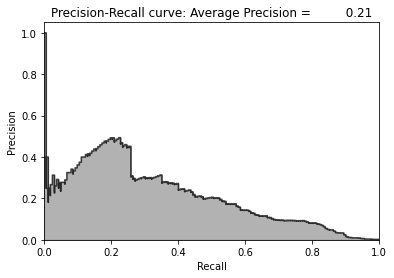

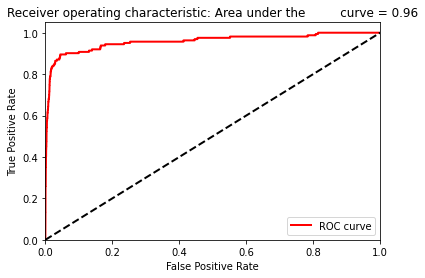

Epoch 1/10
5964/5964 [==============================] - 27s 4ms/step - loss: 0.1621 - accuracy: 0.7275 - val_loss: 0.0077 - val_accuracy: 0.9751
Epoch 2/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0772 - accuracy: 0.7868 - val_loss: 0.0083 - val_accuracy: 0.9716
Epoch 3/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0758 - accuracy: 0.7857 - val_loss: 0.0214 - val_accuracy: 0.9444
Epoch 4/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0764 - accuracy: 0.7866 - val_loss: 0.0077 - val_accuracy: 0.9747
Epoch 5/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0760 - accuracy: 0.7860 - val_loss: 0.0074 - val_accuracy: 0.9743
Epoch 6/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0783 - accuracy: 0.7867 - val_loss: 0.0068 - val_accuracy: 0.9794
Epoch 7/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0773 - accuracy: 0.7860 - val_loss: 0.0088 - val_ac

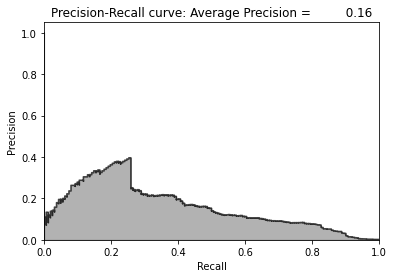

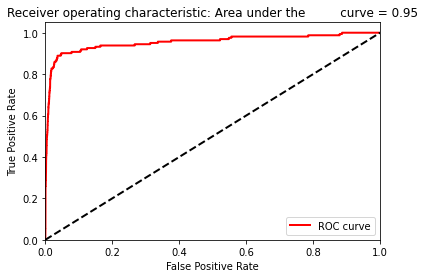

Epoch 1/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.1365 - accuracy: 0.7430 - val_loss: 0.0075 - val_accuracy: 0.9796
Epoch 2/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0762 - accuracy: 0.7867 - val_loss: 0.0077 - val_accuracy: 0.9733
Epoch 3/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0762 - accuracy: 0.7857 - val_loss: 0.0079 - val_accuracy: 0.9768
Epoch 4/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0765 - accuracy: 0.7851 - val_loss: 0.0071 - val_accuracy: 0.9766
Epoch 5/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0769 - accuracy: 0.7853 - val_loss: 0.0071 - val_accuracy: 0.9788
Epoch 6/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0771 - accuracy: 0.7852 - val_loss: 0.0078 - val_accuracy: 0.9753
Epoch 7/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0765 - accuracy: 0.7853 - val_loss: 0.0070 - val_ac

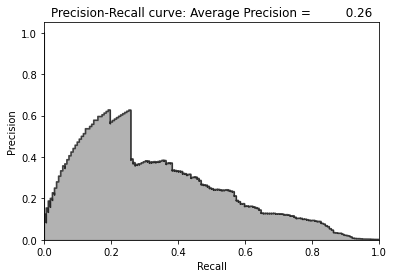

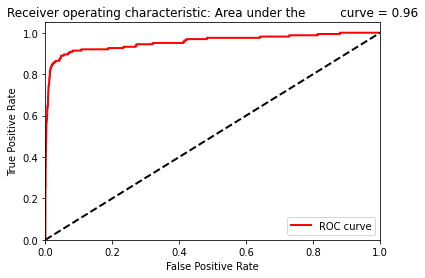

Mean average precision over 10 runs:  0.22594707137973905


[0.21151560358734842,
 0.31904273659911914,
 0.17545426119515936,
 0.27399998263097713,
 0.211051287142536,
 0.22535584409579865,
 0.2113582821787158,
 0.2145767518591511,
 0.1585645856164645,
 0.25855137889212054]

In [ ]:
# 평균 정밀도의 평균 계산을 위해 10번 반복 실행
test_scores = []
for i in range(0,10):
    # 신경망 API 호출
    model = Sequential()

    model.add(Dense(units=40, activation='linear',input_dim=29))
    # 10%의 dropout 추가
    model.add(Dropout(0.10))

    # 29개 노드를 가진 출력층 생성
    model.add(Dense(units=29, activation='linear'))

    # 모델 컴파일
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # 모델 훈련
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # 테스트 셋에 대한 평가
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

In [ ]:
# 결과
print("Mean average precision over 10 runs: ", np.mean(test_scores))
print("Coefficient of variation over 10 runs: ", np.std(test_scores)/ \
                                                np.mean(test_scores))
test_scores

Mean average precision over 10 runs:  0.22594707137973905
Coefficient of variation over 10 runs:  0.197440314244374


[0.21151560358734842,
 0.31904273659911914,
 0.17545426119515936,
 0.27399998263097713,
 0.211051287142536,
 0.22535584409579865,
 0.2113582821787158,
 0.2145767518591511,
 0.1585645856164645,
 0.25855137889212054]

평균 정밀도는 0.23으로 기존의 다른 방법들보다 낮은 것을 알 수 있습니다.

또한, 변동계수는 0.20입니다.

즉, 과대 적합된 과대 완전 오토 인코더를 사용한 신용카드 사기 거래 탐지 모델은 낮은 성능을 보입니다.

6.9 선형 활성화 함수를 가진 2-계층 희소 과대완전 오토인코더(은닉층 40개 노드)

- 정규화 방법 중 하나인 희소성을 이용한 모델링입니다.
- 희소 과대 완전 오토인코더란 행렬의 희소성을 고려하여 오토 인코더의 대다수의 뉴런을 비활성 상태로 만들게 됩니다.
- 이렇게 되면 오토인코더가 항등함수를 학습하기 어려워져 관측치 들을 쉽게 과대 적합할 수 없게 됩니다.

Epoch 1/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0803 - accuracy: 0.9155 - val_loss: 0.0028 - val_accuracy: 0.9938
Epoch 2/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0035 - accuracy: 0.9938 - val_loss: 0.0036 - val_accuracy: 0.9885
Epoch 3/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0030 - accuracy: 0.9919 - val_loss: 0.0021 - val_accuracy: 0.9962
Epoch 4/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0028 - accuracy: 0.9922 - val_loss: 0.0018 - val_accuracy: 0.9948
Epoch 5/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0027 - accuracy: 0.9924 - val_loss: 0.0017 - val_accuracy: 0.9970
Epoch 6/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0024 - accuracy: 0.9930 - val_loss: 0.0031 - val_accuracy: 0.9924
Epoch 7/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0022 - accuracy: 0.9933 - val_loss: 0.0014 - val_ac

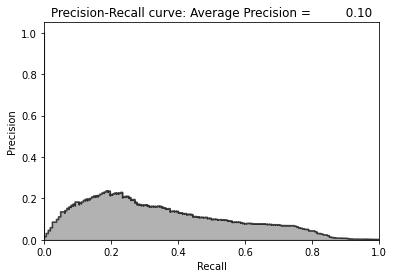

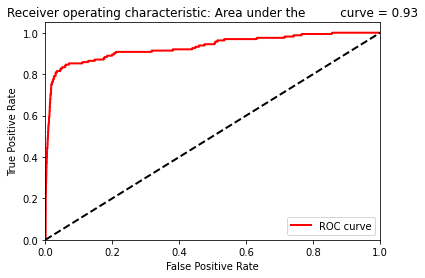

Epoch 1/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0558 - accuracy: 0.9286 - val_loss: 0.0028 - val_accuracy: 0.9965
Epoch 2/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0034 - accuracy: 0.9933 - val_loss: 0.0022 - val_accuracy: 0.9957
Epoch 3/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0031 - accuracy: 0.9930 - val_loss: 0.0022 - val_accuracy: 0.9935
Epoch 4/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0029 - accuracy: 0.9936 - val_loss: 0.0018 - val_accuracy: 0.9958
Epoch 5/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0025 - accuracy: 0.9935 - val_loss: 0.0016 - val_accuracy: 0.9988
Epoch 6/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0023 - accuracy: 0.9927 - val_loss: 0.0019 - val_accuracy: 0.9888
Epoch 7/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0026 - accuracy: 0.9909 - val_loss: 0.0072 - val_ac

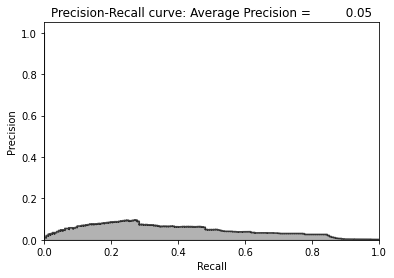

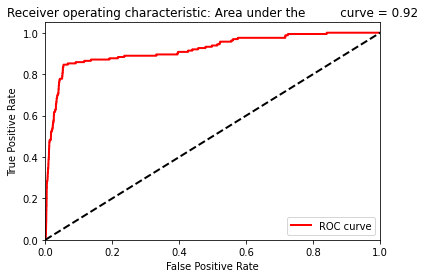

Epoch 1/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0499 - accuracy: 0.9371 - val_loss: 0.0025 - val_accuracy: 0.9988
Epoch 2/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0033 - accuracy: 0.9926 - val_loss: 0.0026 - val_accuracy: 0.9898
Epoch 3/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0028 - accuracy: 0.9927 - val_loss: 0.0019 - val_accuracy: 0.9958
Epoch 4/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0029 - accuracy: 0.9935 - val_loss: 0.0021 - val_accuracy: 0.9913
Epoch 5/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0026 - accuracy: 0.9923 - val_loss: 0.0016 - val_accuracy: 0.9963
Epoch 6/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0027 - accuracy: 0.9915 - val_loss: 0.0062 - val_accuracy: 0.9758
Epoch 7/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0024 - accuracy: 0.9926 - val_loss: 0.0019 - val_ac

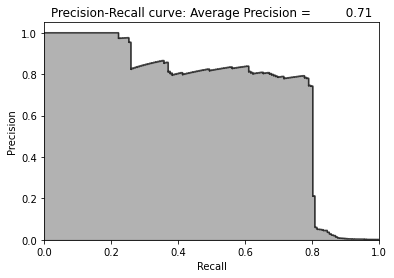

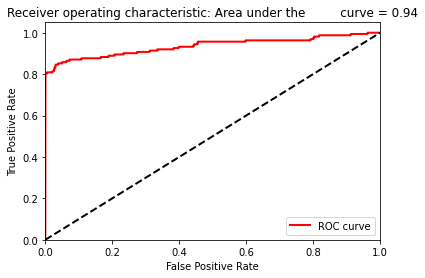

Epoch 1/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0557 - accuracy: 0.9330 - val_loss: 0.0074 - val_accuracy: 0.9833
Epoch 2/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0037 - accuracy: 0.9924 - val_loss: 0.0068 - val_accuracy: 0.9627
Epoch 3/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0026 - accuracy: 0.9932 - val_loss: 0.0019 - val_accuracy: 0.9962
Epoch 4/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0027 - accuracy: 0.9921 - val_loss: 0.0017 - val_accuracy: 0.9993
Epoch 5/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0027 - accuracy: 0.9933 - val_loss: 0.0016 - val_accuracy: 0.9994
Epoch 6/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0030 - accuracy: 0.9916 - val_loss: 0.0015 - val_accuracy: 0.9994
Epoch 7/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0025 - accuracy: 0.9932 - val_loss: 0.0014 - val_ac

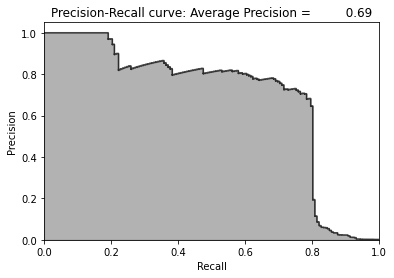

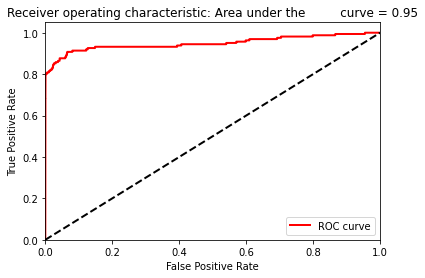

Epoch 1/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0659 - accuracy: 0.9234 - val_loss: 0.0027 - val_accuracy: 0.9953
Epoch 2/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0033 - accuracy: 0.9937 - val_loss: 0.0074 - val_accuracy: 0.9720
Epoch 3/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0032 - accuracy: 0.9926 - val_loss: 0.0025 - val_accuracy: 0.9854
Epoch 4/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0024 - accuracy: 0.9933 - val_loss: 0.0038 - val_accuracy: 0.9815
Epoch 5/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0025 - accuracy: 0.9924 - val_loss: 0.0015 - val_accuracy: 0.9996
Epoch 6/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0034 - accuracy: 0.9908 - val_loss: 0.0021 - val_accuracy: 0.9917
Epoch 7/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0022 - accuracy: 0.9935 - val_loss: 0.0024 - val_ac

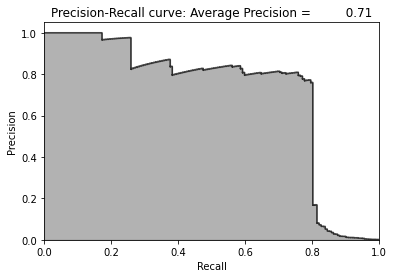

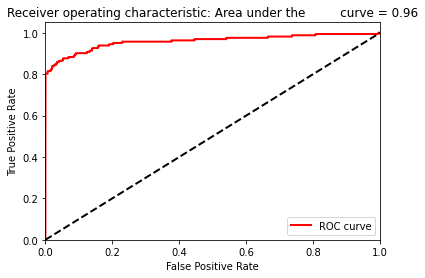

Epoch 1/10
5964/5964 [==============================] - 27s 4ms/step - loss: 0.0461 - accuracy: 0.9402 - val_loss: 0.0027 - val_accuracy: 0.9949
Epoch 2/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0035 - accuracy: 0.9929 - val_loss: 0.0022 - val_accuracy: 0.9994
Epoch 3/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0028 - accuracy: 0.9939 - val_loss: 0.0019 - val_accuracy: 0.9991
Epoch 4/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0025 - accuracy: 0.9939 - val_loss: 0.0017 - val_accuracy: 0.9987
Epoch 5/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0025 - accuracy: 0.9917 - val_loss: 0.0016 - val_accuracy: 0.9973
Epoch 6/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0025 - accuracy: 0.9928 - val_loss: 0.0015 - val_accuracy: 0.9996
Epoch 7/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0025 - accuracy: 0.9916 - val_loss: 0.0014 - val_ac

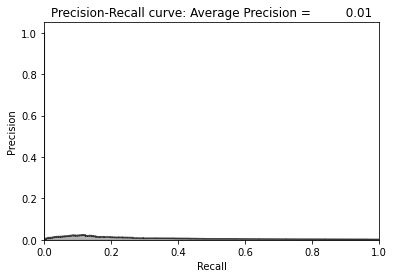

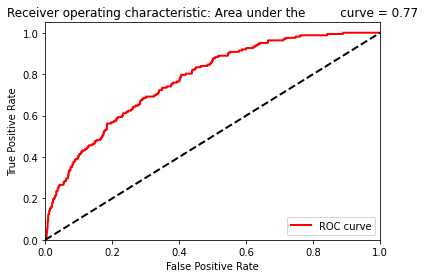

Epoch 1/10
5964/5964 [==============================] - 27s 4ms/step - loss: 0.1068 - accuracy: 0.8842 - val_loss: 0.0096 - val_accuracy: 0.9761
Epoch 2/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0038 - accuracy: 0.9908 - val_loss: 0.0023 - val_accuracy: 0.9983
Epoch 3/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0029 - accuracy: 0.9937 - val_loss: 0.0027 - val_accuracy: 0.9905
Epoch 4/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0029 - accuracy: 0.9927 - val_loss: 0.0018 - val_accuracy: 0.9970
Epoch 5/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0024 - accuracy: 0.9925 - val_loss: 0.0016 - val_accuracy: 0.9991
Epoch 6/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0023 - accuracy: 0.9911 - val_loss: 0.0030 - val_accuracy: 0.9829
Epoch 7/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0027 - accuracy: 0.9921 - val_loss: 0.0039 - val_ac

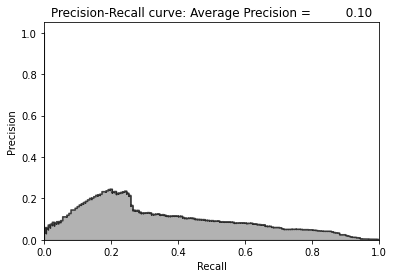

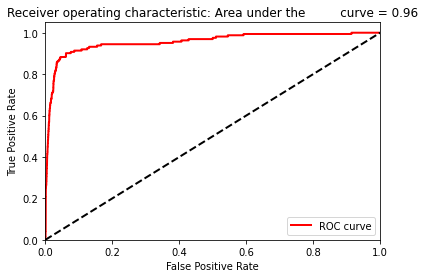

Epoch 1/10
5964/5964 [==============================] - 27s 4ms/step - loss: 0.0493 - accuracy: 0.9433 - val_loss: 0.0031 - val_accuracy: 0.9899
Epoch 2/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0031 - accuracy: 0.9938 - val_loss: 0.0024 - val_accuracy: 0.9914
Epoch 3/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0028 - accuracy: 0.9924 - val_loss: 0.0019 - val_accuracy: 0.9952
Epoch 4/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0026 - accuracy: 0.9933 - val_loss: 0.0016 - val_accuracy: 0.9995
Epoch 5/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0026 - accuracy: 0.9923 - val_loss: 0.0018 - val_accuracy: 0.9974
Epoch 6/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0029 - accuracy: 0.9917 - val_loss: 0.0015 - val_accuracy: 0.9988
Epoch 7/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0023 - accuracy: 0.9927 - val_loss: 0.0014 - val_ac

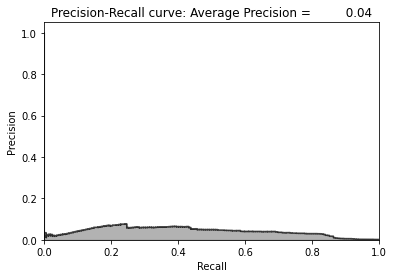

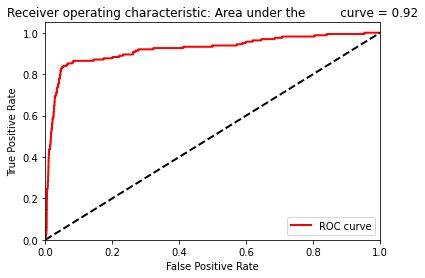

Epoch 1/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0536 - accuracy: 0.9363 - val_loss: 0.0025 - val_accuracy: 0.9974
Epoch 2/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0041 - accuracy: 0.9918 - val_loss: 0.0022 - val_accuracy: 0.9980
Epoch 3/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0030 - accuracy: 0.9926 - val_loss: 0.0019 - val_accuracy: 0.9977
Epoch 4/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0026 - accuracy: 0.9921 - val_loss: 0.0027 - val_accuracy: 0.9875
Epoch 5/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0025 - accuracy: 0.9918 - val_loss: 0.0018 - val_accuracy: 0.9937
Epoch 6/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0022 - accuracy: 0.9918 - val_loss: 0.0028 - val_accuracy: 0.9875
Epoch 7/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0024 - accuracy: 0.9916 - val_loss: 0.0023 - val_ac

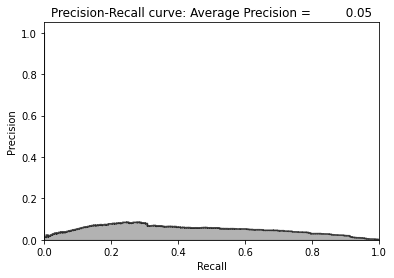

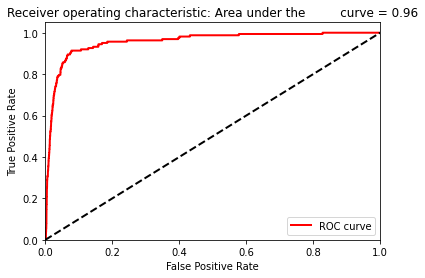

Epoch 1/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.1239 - accuracy: 0.8804 - val_loss: 0.0034 - val_accuracy: 0.9921
Epoch 2/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0034 - accuracy: 0.9919 - val_loss: 0.0022 - val_accuracy: 0.9994
Epoch 3/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0043 - accuracy: 0.9910 - val_loss: 0.0106 - val_accuracy: 0.9727
Epoch 4/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0024 - accuracy: 0.9939 - val_loss: 0.0018 - val_accuracy: 0.9967
Epoch 5/10
5964/5964 [==============================] - 27s 4ms/step - loss: 0.0027 - accuracy: 0.9932 - val_loss: 0.0017 - val_accuracy: 0.9982
Epoch 6/10
5964/5964 [==============================] - 27s 4ms/step - loss: 0.0025 - accuracy: 0.9920 - val_loss: 0.0016 - val_accuracy: 0.9978
Epoch 7/10
5964/5964 [==============================] - 27s 4ms/step - loss: 0.0024 - accuracy: 0.9917 - val_loss: 0.0014 - val_ac

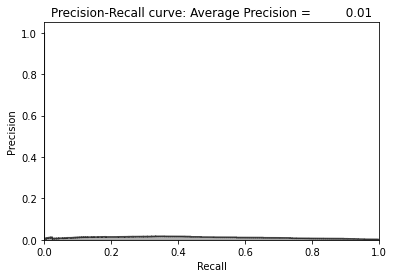

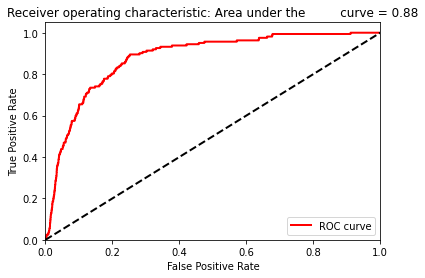

Mean average precision over 10 runs:  0.24627109917439483


[0.10454277533659677,
 0.0464421387950104,
 0.7057224943012338,
 0.6902310415065176,
 0.7092282448382091,
 0.007554102133747698,
 0.09777934452514074,
 0.04123805377385676,
 0.0488585641321692,
 0.01111423240146629]

In [ ]:
# 평균 정밀도의 평균 계산을 위해 10번 반복 실행합니다.
test_scores = []
for i in range(0,10):
    # 신경망 API 호출
    model = Sequential()
    # 드롭아웃이 아닌 희소 패널티 만을 사용합니다.
    model.add(Dense(units=40, activation='linear',  \
        activity_regularizer=regularizers.l1(10e-5), input_dim=29))

    # 29개 노드를 가진 출력층 생성
    model.add(Dense(units=29, activation='linear'))

    # 모델 컴파일
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # 모델 훈련
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # 테스트 셋에 대한 평가
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

In [ ]:
# 결과
print("Mean average precision over 10 runs: ", np.mean(test_scores))
print("Coefficient of variation over 10 runs: ", np.std(test_scores)/ \
                                                np.mean(test_scores))
test_scores

Mean average precision over 10 runs:  0.24627109917439483
Coefficient of variation over 10 runs:  1.21673990400914


[0.10454277533659677,
 0.0464421387950104,
 0.7057224943012338,
 0.6902310415065176,
 0.7092282448382091,
 0.007554102133747698,
 0.09777934452514074,
 0.04123805377385676,
 0.0488585641321692,
 0.01111423240146629]

평균 정밀도는 0.25으로 기존의 다른 방법들보다 낮은 것을 알 수 있습니다.

또한, 변동계수는 1.22입니다.

즉, 희소 과대 완전 오토 인코더를 사용한 신용카드 사기 거래 탐지 모델 역시, 낮은 성능을 보입니다.

6.10 드롭아웃과 선형 활성화 함수를 가진 2-계층 희소 과대완전 오토인코더(은닉층 40개 노드, 드롭아웃 비율: 5%)

위의 모델들을 개선하기 위해 정규화 기술을 결합하여 모델링을 진행하겠습니다.

Epoch 1/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0910 - accuracy: 0.8156 - val_loss: 0.0054 - val_accuracy: 0.9810
Epoch 2/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0406 - accuracy: 0.8612 - val_loss: 0.0047 - val_accuracy: 0.9817
Epoch 3/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0413 - accuracy: 0.8627 - val_loss: 0.0042 - val_accuracy: 0.9862
Epoch 4/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0403 - accuracy: 0.8629 - val_loss: 0.0052 - val_accuracy: 0.9758
Epoch 5/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0409 - accuracy: 0.8618 - val_loss: 0.0076 - val_accuracy: 0.9750
Epoch 6/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0413 - accuracy: 0.8621 - val_loss: 0.0054 - val_accuracy: 0.9729
Epoch 7/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0394 - accuracy: 0.8625 - val_loss: 0.0042 - val_ac

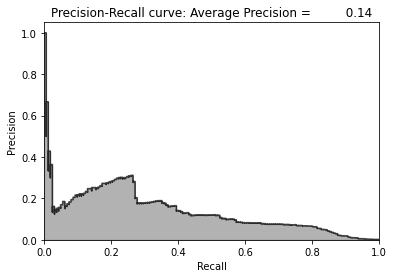

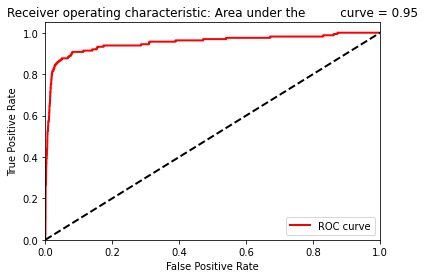

Epoch 1/10
5964/5964 [==============================] - 27s 4ms/step - loss: 0.0877 - accuracy: 0.8167 - val_loss: 0.0057 - val_accuracy: 0.9771
Epoch 2/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0416 - accuracy: 0.8599 - val_loss: 0.0059 - val_accuracy: 0.9778
Epoch 3/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0405 - accuracy: 0.8612 - val_loss: 0.0046 - val_accuracy: 0.9830
Epoch 4/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0418 - accuracy: 0.8613 - val_loss: 0.0042 - val_accuracy: 0.9823
Epoch 5/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0406 - accuracy: 0.8629 - val_loss: 0.0055 - val_accuracy: 0.9809
Epoch 6/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0406 - accuracy: 0.8608 - val_loss: 0.0054 - val_accuracy: 0.9794
Epoch 7/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0405 - accuracy: 0.8616 - val_loss: 0.0190 - val_ac

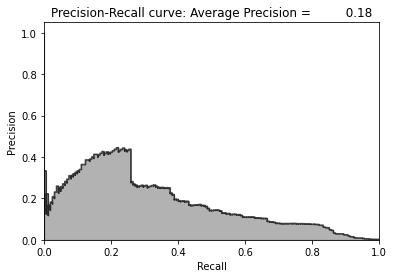

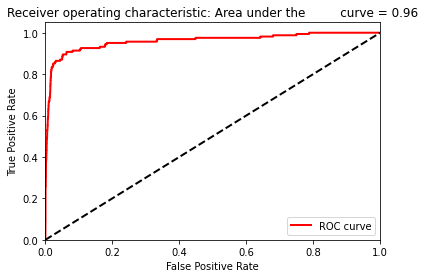

Epoch 1/10
5964/5964 [==============================] - 27s 4ms/step - loss: 0.1005 - accuracy: 0.8051 - val_loss: 0.0061 - val_accuracy: 0.9750
Epoch 2/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0406 - accuracy: 0.8607 - val_loss: 0.0054 - val_accuracy: 0.9776
Epoch 3/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0409 - accuracy: 0.8617 - val_loss: 0.0054 - val_accuracy: 0.9767
Epoch 4/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0411 - accuracy: 0.8617 - val_loss: 0.0043 - val_accuracy: 0.9842
Epoch 5/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0403 - accuracy: 0.8627 - val_loss: 0.0046 - val_accuracy: 0.9803
Epoch 6/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0406 - accuracy: 0.8620 - val_loss: 0.0048 - val_accuracy: 0.9788
Epoch 7/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0405 - accuracy: 0.8627 - val_loss: 0.0118 - val_ac

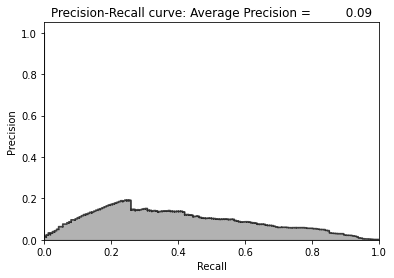

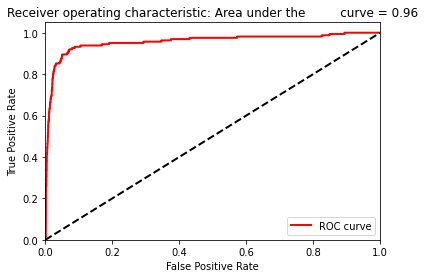

Epoch 1/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.1056 - accuracy: 0.8084 - val_loss: 0.0059 - val_accuracy: 0.9761
Epoch 2/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0406 - accuracy: 0.8619 - val_loss: 0.0057 - val_accuracy: 0.9796
Epoch 3/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0411 - accuracy: 0.8618 - val_loss: 0.0041 - val_accuracy: 0.9849
Epoch 4/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0412 - accuracy: 0.8623 - val_loss: 0.0040 - val_accuracy: 0.9856
Epoch 5/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0408 - accuracy: 0.8608 - val_loss: 0.0048 - val_accuracy: 0.9788
Epoch 6/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0417 - accuracy: 0.8619 - val_loss: 0.0079 - val_accuracy: 0.9752
Epoch 7/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0405 - accuracy: 0.8622 - val_loss: 0.0043 - val_ac

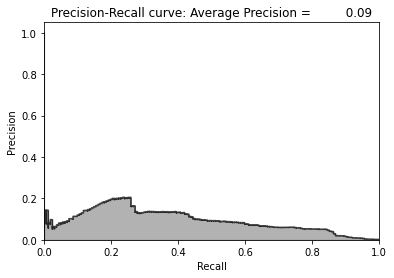

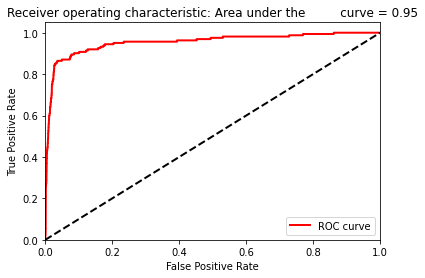

Epoch 1/10
5964/5964 [==============================] - 27s 4ms/step - loss: 0.0948 - accuracy: 0.8128 - val_loss: 0.0050 - val_accuracy: 0.9795
Epoch 2/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0430 - accuracy: 0.8609 - val_loss: 0.0047 - val_accuracy: 0.9822
Epoch 3/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0408 - accuracy: 0.8603 - val_loss: 0.0056 - val_accuracy: 0.9750
Epoch 4/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0408 - accuracy: 0.8609 - val_loss: 0.0149 - val_accuracy: 0.9612
Epoch 5/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0407 - accuracy: 0.8602 - val_loss: 0.0041 - val_accuracy: 0.9830
Epoch 6/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0406 - accuracy: 0.8609 - val_loss: 0.0057 - val_accuracy: 0.9777
Epoch 7/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0409 - accuracy: 0.8602 - val_loss: 0.0044 - val_ac

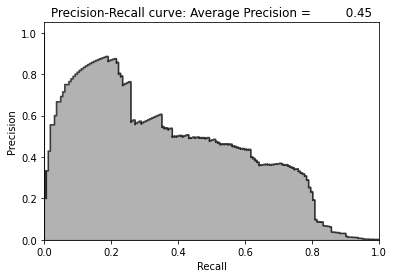

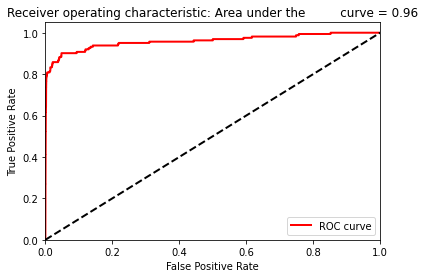

Epoch 1/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0998 - accuracy: 0.8100 - val_loss: 0.0058 - val_accuracy: 0.9766
Epoch 2/10
5964/5964 [==============================] - 27s 4ms/step - loss: 0.0413 - accuracy: 0.8614 - val_loss: 0.0052 - val_accuracy: 0.9823
Epoch 3/10
5964/5964 [==============================] - 27s 4ms/step - loss: 0.0405 - accuracy: 0.8625 - val_loss: 0.0049 - val_accuracy: 0.9820
Epoch 4/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0405 - accuracy: 0.8627 - val_loss: 0.0042 - val_accuracy: 0.9832
Epoch 5/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0394 - accuracy: 0.8629 - val_loss: 0.0043 - val_accuracy: 0.9853
Epoch 6/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0405 - accuracy: 0.8612 - val_loss: 0.0055 - val_accuracy: 0.9794
Epoch 7/10
5964/5964 [==============================] - 27s 4ms/step - loss: 0.0402 - accuracy: 0.8621 - val_loss: 0.0042 - val_ac

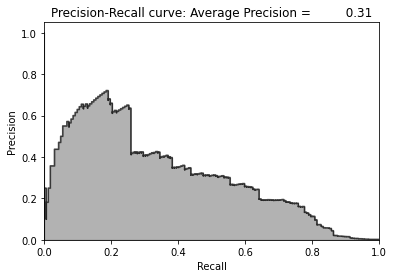

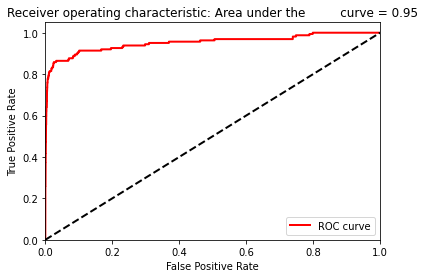

Epoch 1/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0994 - accuracy: 0.8142 - val_loss: 0.0119 - val_accuracy: 0.9627
Epoch 2/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0406 - accuracy: 0.8629 - val_loss: 0.0052 - val_accuracy: 0.9752
Epoch 3/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0408 - accuracy: 0.8634 - val_loss: 0.0078 - val_accuracy: 0.9747
Epoch 4/10
5964/5964 [==============================] - 27s 4ms/step - loss: 0.0407 - accuracy: 0.8628 - val_loss: 0.0048 - val_accuracy: 0.9813
Epoch 5/10
5964/5964 [==============================] - 27s 4ms/step - loss: 0.0406 - accuracy: 0.8632 - val_loss: 0.0044 - val_accuracy: 0.9810
Epoch 6/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0394 - accuracy: 0.8634 - val_loss: 0.0046 - val_accuracy: 0.9795
Epoch 7/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0414 - accuracy: 0.8628 - val_loss: 0.0043 - val_ac

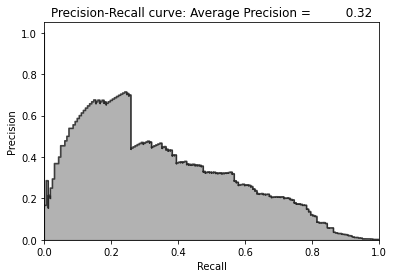

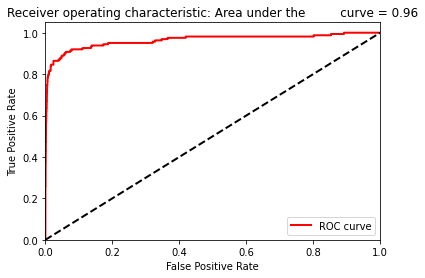

Epoch 1/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0981 - accuracy: 0.8089 - val_loss: 0.0055 - val_accuracy: 0.9782
Epoch 2/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0412 - accuracy: 0.8614 - val_loss: 0.0063 - val_accuracy: 0.9746
Epoch 3/10
5964/5964 [==============================] - 27s 5ms/step - loss: 0.0409 - accuracy: 0.8603 - val_loss: 0.0053 - val_accuracy: 0.9767
Epoch 4/10
5964/5964 [==============================] - 27s 4ms/step - loss: 0.0405 - accuracy: 0.8617 - val_loss: 0.0056 - val_accuracy: 0.9771
Epoch 5/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0399 - accuracy: 0.8610 - val_loss: 0.0041 - val_accuracy: 0.9832
Epoch 6/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0394 - accuracy: 0.8633 - val_loss: 0.0040 - val_accuracy: 0.9826
Epoch 7/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0404 - accuracy: 0.8610 - val_loss: 0.0050 - val_ac

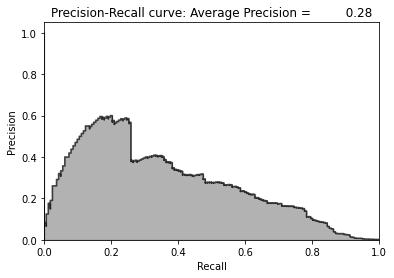

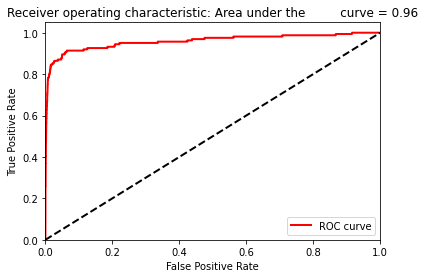

Epoch 1/10
5964/5964 [==============================] - 27s 4ms/step - loss: 0.0979 - accuracy: 0.8095 - val_loss: 0.0100 - val_accuracy: 0.9684
Epoch 2/10
5964/5964 [==============================] - 27s 4ms/step - loss: 0.0415 - accuracy: 0.8603 - val_loss: 0.0045 - val_accuracy: 0.9840
Epoch 3/10
5964/5964 [==============================] - 27s 4ms/step - loss: 0.0398 - accuracy: 0.8617 - val_loss: 0.0052 - val_accuracy: 0.9754
Epoch 4/10
5964/5964 [==============================] - 27s 4ms/step - loss: 0.0400 - accuracy: 0.8616 - val_loss: 0.0048 - val_accuracy: 0.9817
Epoch 5/10
5964/5964 [==============================] - 27s 4ms/step - loss: 0.0414 - accuracy: 0.8612 - val_loss: 0.0043 - val_accuracy: 0.9835
Epoch 6/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0409 - accuracy: 0.8613 - val_loss: 0.0055 - val_accuracy: 0.9797
Epoch 7/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0412 - accuracy: 0.8604 - val_loss: 0.0037 - val_ac

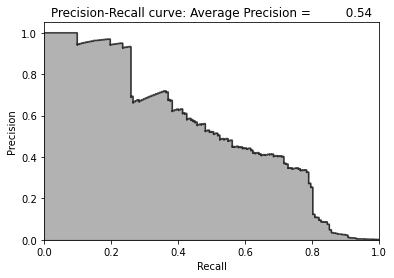

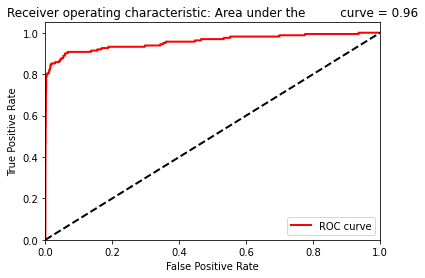

Epoch 1/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.1074 - accuracy: 0.8059 - val_loss: 0.0051 - val_accuracy: 0.9824
Epoch 2/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0412 - accuracy: 0.8625 - val_loss: 0.0044 - val_accuracy: 0.9829
Epoch 3/10
5964/5964 [==============================] - 27s 4ms/step - loss: 0.0407 - accuracy: 0.8621 - val_loss: 0.0043 - val_accuracy: 0.9839
Epoch 4/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0417 - accuracy: 0.8608 - val_loss: 0.0041 - val_accuracy: 0.9832
Epoch 5/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0403 - accuracy: 0.8622 - val_loss: 0.0044 - val_accuracy: 0.9803
Epoch 6/10
5964/5964 [==============================] - 27s 5ms/step - loss: 0.0404 - accuracy: 0.8623 - val_loss: 0.0045 - val_accuracy: 0.9806
Epoch 7/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0406 - accuracy: 0.8625 - val_loss: 0.0048 - val_ac

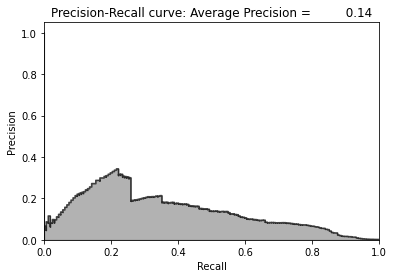

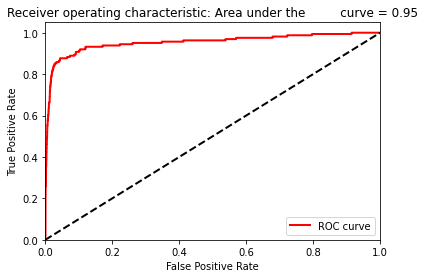

Mean average precision over 10 runs:  0.2546797658777759


[0.1400115200943394,
 0.1810447007361078,
 0.09109747696743294,
 0.0936761746694779,
 0.4512595853981701,
 0.3140582047081304,
 0.3249385495793922,
 0.2754173653128392,
 0.5373853671660666,
 0.13790871414580252]

In [ ]:
# 평균 정밀도의 평균 계산을 위해 10번 반복 실행합니다.
test_scores = []
for i in range(0,10):
    # 신경망 API 호출
    model = Sequential()
    # 활성화 함수로 선형 함수를 이용하고 단일 은닉층을 사용합니다.
    model.add(Dense(units=40, activation='linear',  \
        activity_regularizer=regularizers.l1(10e-5), input_dim=29))
    model.add(Dropout(0.05))
    #그리고 5%의 드롭아웃을 설정합니다.
    model.add(Dense(units=29, activation='linear'))

    # 모델 컴파일
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # 모델 훈련
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # 테스트 셋에 대한 평가
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

In [ ]:
# 결과
print("Mean average precision over 10 runs: ", np.mean(test_scores))
print("Coefficient of variation over 10 runs: ", np.std(test_scores)/ \
                                                np.mean(test_scores))
test_scores

Mean average precision over 10 runs:  0.2546797658777759
Coefficient of variation over 10 runs:  0.5721732566258699


[0.1400115200943394,
 0.1810447007361078,
 0.09109747696743294,
 0.0936761746694779,
 0.4512595853981701,
 0.3140582047081304,
 0.3249385495793922,
 0.2754173653128392,
 0.5373853671660666,
 0.13790871414580252]

평균 정밀도는 0.25이고 변동계수는 0.57입니다.

즉, 이 모델 역시 낮은 성능을 보입니다.

6.11 노이즈 데이터 셋 


현실 세계에서는 노이즈 데이터로 인한 데이터 왜곡이 많기 때문에 이를 고려한 오토인코더 방법이 필요합니다. 따라서 노이즈 데이터를 생성한 후, 모델링을 진행하겠습니다.

노이즈 데이터는 기존 신용카드 거래 데이터셋에 가우시안 랜덤 행렬을 추가하여 생성하겠습니다. 그 후, 오토인코더 학습을 진행하겠습니다.

In [ ]:
noise_factor = 0.50
X_train_AE_noisy = X_train_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_train_AE.shape)
X_test_AE_noisy = X_test_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_test_AE.shape) 

6.12 노이즈 제거 오토인코더

앞에서 만든 노이즈 데이터를 추가한 데이트 셋을 이용하여 오토 인코더를 진행하겠습니다.
이 때, 우리는 노이즈는 재구성하지 않으면서 나머지 관측치를 충분히 재구성하도록 만드는 오토인코더 모델을 찾아야 합니다.

27개 노드의 단일 은닉층과 선형 활성화 함수로 구성된 과소 완전 오토인코더, 드롭아웃 및 40개 노드의 단일 은닉층으로 구성된 희소 과대완전 오토인코더, 비선형 활성화 함수를 가진 오토 인코더 모델링을 진행해보겠습니다.

6.12.1 선형 활성화 함수를 가진 2-계층 노이즈 제거 과소완전 오토인코더(은닉층 27개 노드)

Epoch 1/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.1450 - accuracy: 0.7885 - val_loss: 0.0391 - val_accuracy: 0.9352
Epoch 2/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0568 - accuracy: 0.9046 - val_loss: 0.0364 - val_accuracy: 0.9546
Epoch 3/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0552 - accuracy: 0.9075 - val_loss: 0.0367 - val_accuracy: 0.9628
Epoch 4/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0561 - accuracy: 0.9124 - val_loss: 0.0370 - val_accuracy: 0.9586
Epoch 5/10
5964/5964 [==============================] - 22s 4ms/step - loss: 0.0559 - accuracy: 0.9117 - val_loss: 0.0364 - val_accuracy: 0.9664
Epoch 6/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0559 - accuracy: 0.9135 - val_loss: 0.0366 - val_accuracy: 0.9580
Epoch 7/10
5964/5964 [==============================] - 22s 4ms/step - loss: 0.0553 - accuracy: 0.9099 - val_loss: 0.0369 - val_ac

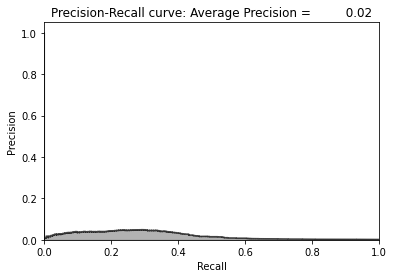

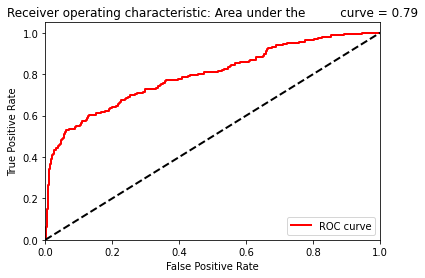

Epoch 1/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.1314 - accuracy: 0.8088 - val_loss: 0.0368 - val_accuracy: 0.9081
Epoch 2/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0575 - accuracy: 0.8863 - val_loss: 0.0358 - val_accuracy: 0.9390
Epoch 3/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0552 - accuracy: 0.8941 - val_loss: 0.0358 - val_accuracy: 0.9476
Epoch 4/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0552 - accuracy: 0.8911 - val_loss: 0.0401 - val_accuracy: 0.9509
Epoch 5/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0556 - accuracy: 0.8986 - val_loss: 0.0363 - val_accuracy: 0.9574
Epoch 6/10
5964/5964 [==============================] - 22s 4ms/step - loss: 0.0553 - accuracy: 0.9052 - val_loss: 0.0365 - val_accuracy: 0.9559
Epoch 7/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0550 - accuracy: 0.9080 - val_loss: 0.0380 - val_ac

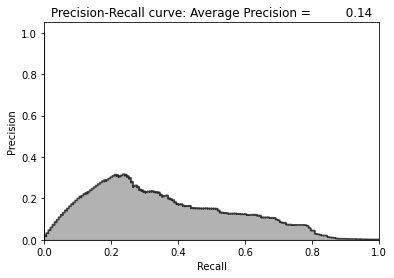

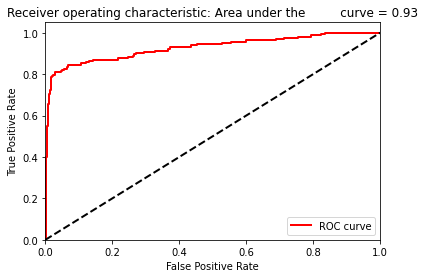

Epoch 1/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.1311 - accuracy: 0.7758 - val_loss: 0.0359 - val_accuracy: 0.8500
Epoch 2/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0577 - accuracy: 0.8443 - val_loss: 0.0358 - val_accuracy: 0.8936
Epoch 3/10
5964/5964 [==============================] - 22s 4ms/step - loss: 0.0556 - accuracy: 0.8603 - val_loss: 0.0359 - val_accuracy: 0.8972
Epoch 4/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0567 - accuracy: 0.8930 - val_loss: 0.0368 - val_accuracy: 0.9425
Epoch 5/10
5964/5964 [==============================] - 22s 4ms/step - loss: 0.0559 - accuracy: 0.9001 - val_loss: 0.0373 - val_accuracy: 0.9310
Epoch 6/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0564 - accuracy: 0.9015 - val_loss: 0.0368 - val_accuracy: 0.9540
Epoch 7/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0562 - accuracy: 0.9120 - val_loss: 0.0364 - val_ac

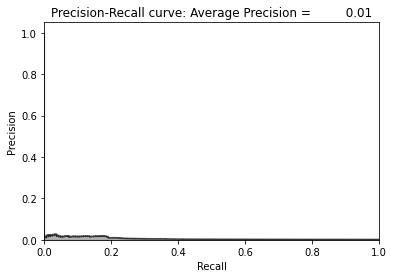

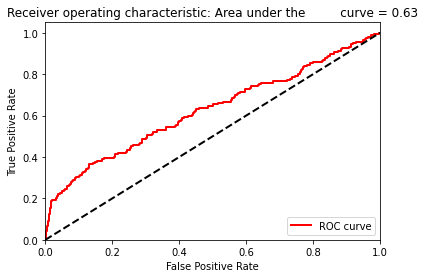

Epoch 1/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.1827 - accuracy: 0.7461 - val_loss: 0.0372 - val_accuracy: 0.9028
Epoch 2/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0580 - accuracy: 0.8843 - val_loss: 0.0367 - val_accuracy: 0.9410
Epoch 3/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0568 - accuracy: 0.9015 - val_loss: 0.0370 - val_accuracy: 0.9414
Epoch 4/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0564 - accuracy: 0.9053 - val_loss: 0.0366 - val_accuracy: 0.9576
Epoch 5/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0562 - accuracy: 0.9077 - val_loss: 0.0367 - val_accuracy: 0.9576
Epoch 6/10
5964/5964 [==============================] - 22s 4ms/step - loss: 0.0556 - accuracy: 0.9124 - val_loss: 0.0373 - val_accuracy: 0.9568
Epoch 7/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0560 - accuracy: 0.9110 - val_loss: 0.0369 - val_ac

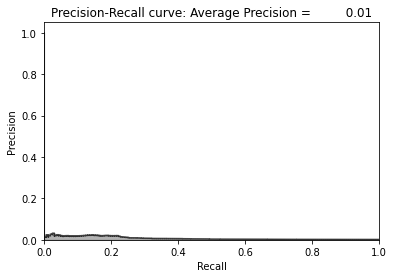

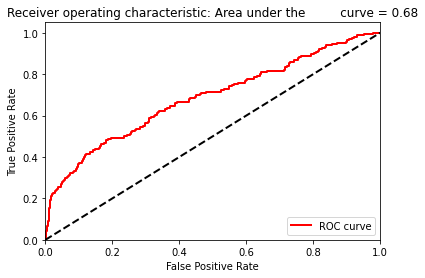

Epoch 1/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.1457 - accuracy: 0.7785 - val_loss: 0.0366 - val_accuracy: 0.9092
Epoch 2/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0562 - accuracy: 0.8782 - val_loss: 0.0369 - val_accuracy: 0.9397
Epoch 3/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0565 - accuracy: 0.8938 - val_loss: 0.0365 - val_accuracy: 0.9264
Epoch 4/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0560 - accuracy: 0.8912 - val_loss: 0.0366 - val_accuracy: 0.9448
Epoch 5/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0562 - accuracy: 0.9004 - val_loss: 0.0365 - val_accuracy: 0.9523
Epoch 6/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0552 - accuracy: 0.9065 - val_loss: 0.0367 - val_accuracy: 0.9562
Epoch 7/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0548 - accuracy: 0.9048 - val_loss: 0.0372 - val_ac

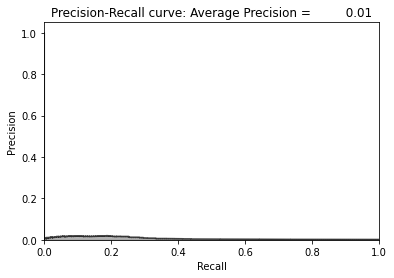

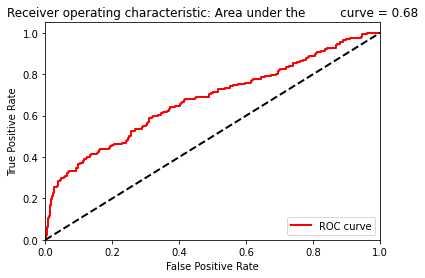

Epoch 1/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.1499 - accuracy: 0.7854 - val_loss: 0.0369 - val_accuracy: 0.9094
Epoch 2/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0550 - accuracy: 0.8709 - val_loss: 0.0349 - val_accuracy: 0.8921
Epoch 3/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0533 - accuracy: 0.8601 - val_loss: 0.0344 - val_accuracy: 0.9388
Epoch 4/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0527 - accuracy: 0.8812 - val_loss: 0.0344 - val_accuracy: 0.9616
Epoch 5/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0527 - accuracy: 0.8820 - val_loss: 0.0340 - val_accuracy: 0.9585
Epoch 6/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0531 - accuracy: 0.8896 - val_loss: 0.0340 - val_accuracy: 0.9570
Epoch 7/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0521 - accuracy: 0.8889 - val_loss: 0.0346 - val_ac

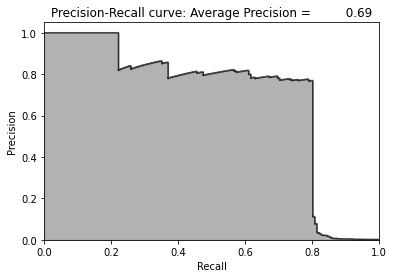

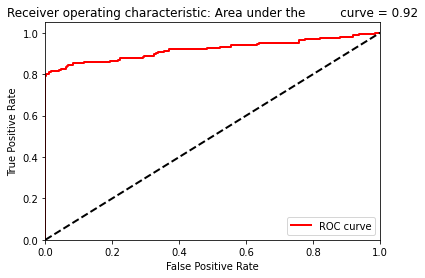

Epoch 1/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.1429 - accuracy: 0.7998 - val_loss: 0.0369 - val_accuracy: 0.9350
Epoch 2/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0590 - accuracy: 0.8949 - val_loss: 0.0372 - val_accuracy: 0.9403
Epoch 3/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0562 - accuracy: 0.8946 - val_loss: 0.0365 - val_accuracy: 0.9489
Epoch 4/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0552 - accuracy: 0.9039 - val_loss: 0.0370 - val_accuracy: 0.9427
Epoch 5/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0567 - accuracy: 0.8997 - val_loss: 0.0367 - val_accuracy: 0.9504
Epoch 6/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0554 - accuracy: 0.9031 - val_loss: 0.0375 - val_accuracy: 0.9544
Epoch 7/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0561 - accuracy: 0.9068 - val_loss: 0.0366 - val_ac

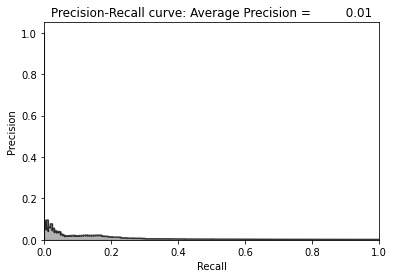

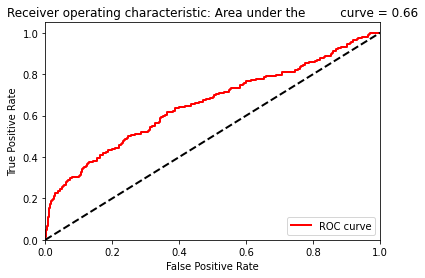

Epoch 1/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.1644 - accuracy: 0.7843 - val_loss: 0.0367 - val_accuracy: 0.9203
Epoch 2/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0553 - accuracy: 0.8864 - val_loss: 0.0359 - val_accuracy: 0.9195
Epoch 3/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0570 - accuracy: 0.8776 - val_loss: 0.0364 - val_accuracy: 0.9167
Epoch 4/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0571 - accuracy: 0.8956 - val_loss: 0.0370 - val_accuracy: 0.9396
Epoch 5/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0557 - accuracy: 0.9073 - val_loss: 0.0366 - val_accuracy: 0.9490
Epoch 6/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0561 - accuracy: 0.9062 - val_loss: 0.0365 - val_accuracy: 0.9552
Epoch 7/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0558 - accuracy: 0.9106 - val_loss: 0.0365 - val_ac

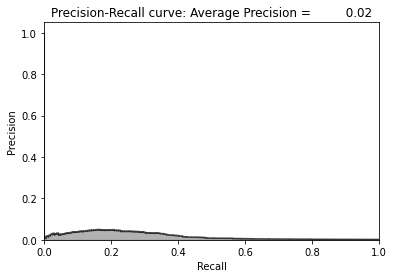

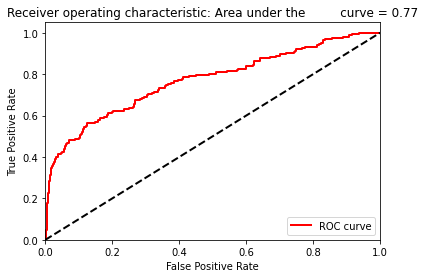

Epoch 1/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.1738 - accuracy: 0.7617 - val_loss: 0.0371 - val_accuracy: 0.8495
Epoch 2/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0538 - accuracy: 0.8315 - val_loss: 0.0377 - val_accuracy: 0.9435
Epoch 3/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0583 - accuracy: 0.8978 - val_loss: 0.0367 - val_accuracy: 0.9466
Epoch 4/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0567 - accuracy: 0.9001 - val_loss: 0.0394 - val_accuracy: 0.9468
Epoch 5/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0559 - accuracy: 0.9039 - val_loss: 0.0373 - val_accuracy: 0.9609
Epoch 6/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0555 - accuracy: 0.9098 - val_loss: 0.0364 - val_accuracy: 0.9576
Epoch 7/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0562 - accuracy: 0.9125 - val_loss: 0.0368 - val_ac

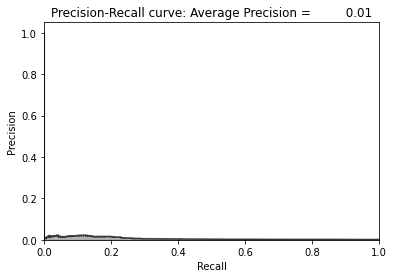

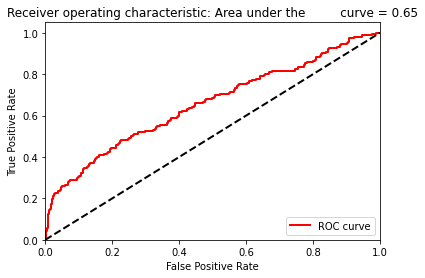

Epoch 1/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.1636 - accuracy: 0.7842 - val_loss: 0.0362 - val_accuracy: 0.8995
Epoch 2/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0556 - accuracy: 0.8697 - val_loss: 0.0365 - val_accuracy: 0.8994
Epoch 3/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0552 - accuracy: 0.8717 - val_loss: 0.0400 - val_accuracy: 0.9093
Epoch 4/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0551 - accuracy: 0.8830 - val_loss: 0.0348 - val_accuracy: 0.9366
Epoch 5/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0548 - accuracy: 0.8927 - val_loss: 0.0365 - val_accuracy: 0.9377
Epoch 6/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0535 - accuracy: 0.8862 - val_loss: 0.0341 - val_accuracy: 0.9446
Epoch 7/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0528 - accuracy: 0.8876 - val_loss: 0.0341 - val_ac

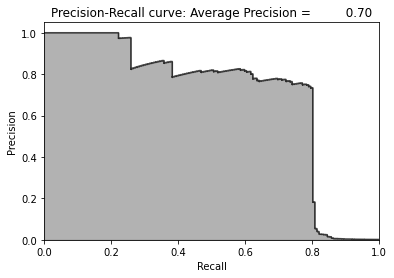

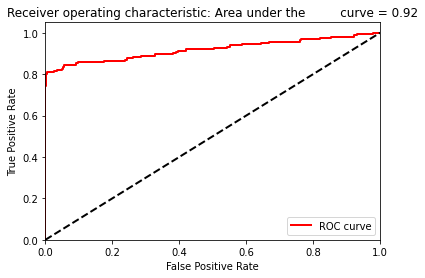

Mean average precision over 10 runs:  0.16036416571052775


[0.020337311581703384,
 0.13669817172373763,
 0.006183328711979597,
 0.007956969121026882,
 0.0071290070517399575,
 0.6931796181040141,
 0.00914335488514043,
 0.017872909677727457,
 0.006517542872072893,
 0.6986234433761351]

In [ ]:
# 10번 실행 - 평균 정밀도의 평균 계산
test_scores = []

for i in range(0,10):
    # 신경망 API 호출
    model = Sequential()

    # 선형 활성화 함수를 가진 27개 노드를 가진 은닉층 생성
    model.add(Dense(units=27, activation='linear', input_dim=29))

    # 29개 노드를 가진 출력층 생성
    model.add(Dense(units=29, activation='linear'))

    # 모델 컴파일
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # 모델 훈련
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE_noisy, y=X_train_AE_noisy,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # 테스트 셋에 대한 평가
    predictions = model.predict(X_test_AE_noisy, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

In [ ]:
# 결과
print("Mean average precision over 10 runs: ", np.mean(test_scores))
print("Coefficient of variation over 10 runs: ", np.std(test_scores)/ \
                                                np.mean(test_scores))
test_scores

Mean average precision over 10 runs:  0.16036416571052775
Coefficient of variation over 10 runs:  1.68609573382374


[0.020337311581703384,
 0.13669817172373763,
 0.006183328711979597,
 0.007956969121026882,
 0.0071290070517399575,
 0.6931796181040141,
 0.00914335488514043,
 0.017872909677727457,
 0.006517542872072893,
 0.6986234433761351]

평균 정밀도는 0.16이고 변동계수는 1.69입니다.

즉, 기존의 노이즈가 없는 데이터만으로 모델링한 결과 대비 낮은 성능을 보입니다.

이처럼, 노이즈 데이터를 제거하는 것이 어렵다는 것을 알 수 있습니다.

6.12.2 선형 활성화 함수를 가진 2-계층 노이즈 제거 과대완전 오토인코더(은닉층 40개 노드, 희소성 정규화, 드롭아웃 비율 : 5%)

마찬가지로 노이즈 데이터를 이용하여 두번째 모델링을 진행해보겠습니다.

Epoch 1/10
5964/5964 [==============================] - 28s 4ms/step - loss: 0.1119 - accuracy: 0.8002 - val_loss: 0.0043 - val_accuracy: 0.9831
Epoch 2/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0508 - accuracy: 0.8464 - val_loss: 0.0044 - val_accuracy: 0.9832
Epoch 3/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0509 - accuracy: 0.8463 - val_loss: 0.0044 - val_accuracy: 0.9826
Epoch 4/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0511 - accuracy: 0.8462 - val_loss: 0.0072 - val_accuracy: 0.9715
Epoch 5/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0500 - accuracy: 0.8472 - val_loss: 0.0040 - val_accuracy: 0.9813
Epoch 6/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0495 - accuracy: 0.8477 - val_loss: 0.0040 - val_accuracy: 0.9816
Epoch 7/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0502 - accuracy: 0.8480 - val_loss: 0.0037 - val_ac

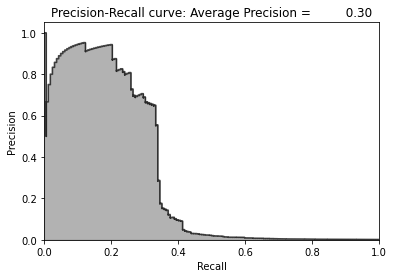

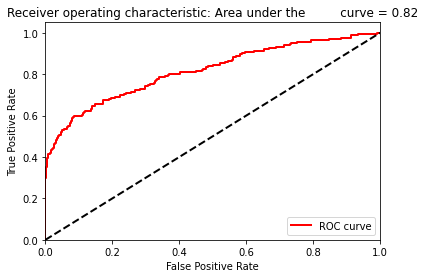

Epoch 1/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.1190 - accuracy: 0.7966 - val_loss: 0.0054 - val_accuracy: 0.9812
Epoch 2/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0516 - accuracy: 0.8454 - val_loss: 0.0043 - val_accuracy: 0.9838
Epoch 3/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0511 - accuracy: 0.8478 - val_loss: 0.0043 - val_accuracy: 0.9839
Epoch 4/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0503 - accuracy: 0.8469 - val_loss: 0.0047 - val_accuracy: 0.9774
Epoch 5/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0501 - accuracy: 0.8485 - val_loss: 0.0039 - val_accuracy: 0.9851
Epoch 6/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0501 - accuracy: 0.8482 - val_loss: 0.0047 - val_accuracy: 0.9821
Epoch 7/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0510 - accuracy: 0.8467 - val_loss: 0.0043 - val_ac

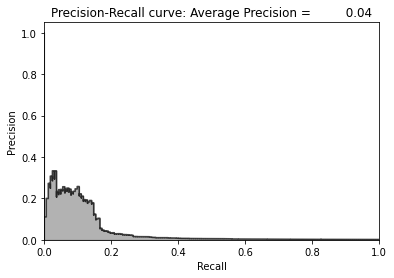

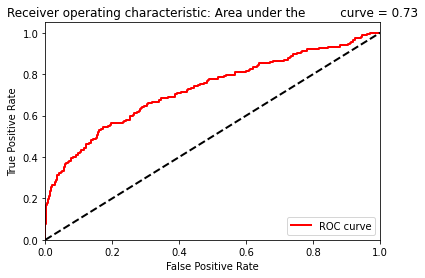

Epoch 1/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.1194 - accuracy: 0.7937 - val_loss: 0.0050 - val_accuracy: 0.9815
Epoch 2/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0519 - accuracy: 0.8458 - val_loss: 0.0041 - val_accuracy: 0.9841
Epoch 3/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0507 - accuracy: 0.8465 - val_loss: 0.0040 - val_accuracy: 0.9805
Epoch 4/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0493 - accuracy: 0.8481 - val_loss: 0.0060 - val_accuracy: 0.9725
Epoch 5/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0504 - accuracy: 0.8476 - val_loss: 0.0041 - val_accuracy: 0.9820
Epoch 6/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0504 - accuracy: 0.8484 - val_loss: 0.0083 - val_accuracy: 0.9713
Epoch 7/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0500 - accuracy: 0.8497 - val_loss: 0.0044 - val_ac

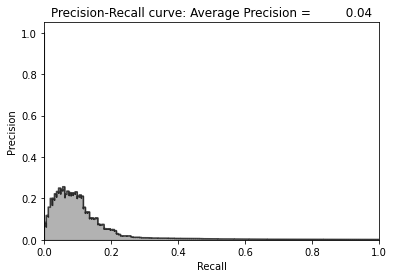

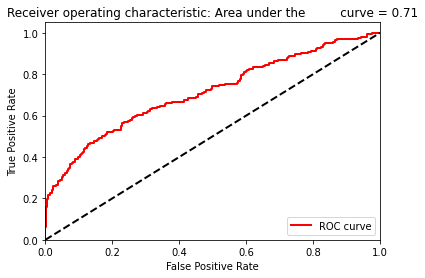

Epoch 1/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.1323 - accuracy: 0.7836 - val_loss: 0.0055 - val_accuracy: 0.9793
Epoch 2/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0512 - accuracy: 0.8461 - val_loss: 0.0047 - val_accuracy: 0.9800
Epoch 3/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0512 - accuracy: 0.8470 - val_loss: 0.0083 - val_accuracy: 0.9749
Epoch 4/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0506 - accuracy: 0.8473 - val_loss: 0.0039 - val_accuracy: 0.9850
Epoch 5/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0510 - accuracy: 0.8463 - val_loss: 0.0042 - val_accuracy: 0.9826
Epoch 6/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0498 - accuracy: 0.8483 - val_loss: 0.0043 - val_accuracy: 0.9827
Epoch 7/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0503 - accuracy: 0.8462 - val_loss: 0.0036 - val_ac

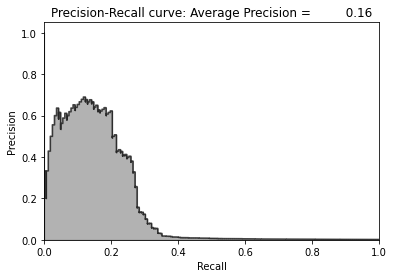

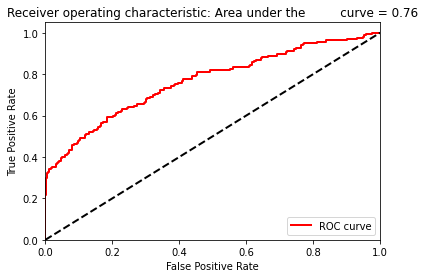

Epoch 1/10
5964/5964 [==============================] - 27s 4ms/step - loss: 0.1221 - accuracy: 0.7945 - val_loss: 0.0058 - val_accuracy: 0.9795
Epoch 2/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0505 - accuracy: 0.8463 - val_loss: 0.0052 - val_accuracy: 0.9797
Epoch 3/10
5964/5964 [==============================] - 37s 6ms/step - loss: 0.0512 - accuracy: 0.8461 - val_loss: 0.0074 - val_accuracy: 0.9771
Epoch 4/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0505 - accuracy: 0.8463 - val_loss: 0.0051 - val_accuracy: 0.9789
Epoch 5/10
5964/5964 [==============================] - 36s 6ms/step - loss: 0.0502 - accuracy: 0.8468 - val_loss: 0.0041 - val_accuracy: 0.9843
Epoch 6/10
5964/5964 [==============================] - 37s 6ms/step - loss: 0.0510 - accuracy: 0.8477 - val_loss: 0.0038 - val_accuracy: 0.9852
Epoch 7/10
5964/5964 [==============================] - 28s 5ms/step - loss: 0.0518 - accuracy: 0.8466 - val_loss: 0.0043 - val_ac

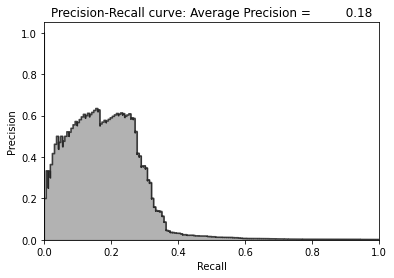

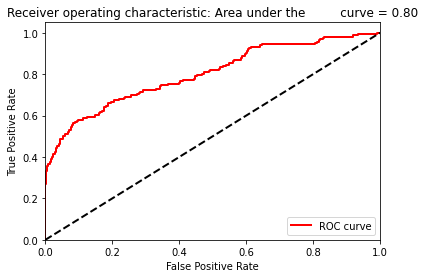

Epoch 1/10
5964/5964 [==============================] - 28s 5ms/step - loss: 0.1121 - accuracy: 0.7983 - val_loss: 0.0046 - val_accuracy: 0.9841
Epoch 2/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0501 - accuracy: 0.8476 - val_loss: 0.0043 - val_accuracy: 0.9803
Epoch 3/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0493 - accuracy: 0.8483 - val_loss: 0.0050 - val_accuracy: 0.9789
Epoch 4/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0502 - accuracy: 0.8470 - val_loss: 0.0057 - val_accuracy: 0.9737
Epoch 5/10
5964/5964 [==============================] - 28s 5ms/step - loss: 0.0493 - accuracy: 0.8475 - val_loss: 0.0041 - val_accuracy: 0.9831
Epoch 6/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0503 - accuracy: 0.8473 - val_loss: 0.0044 - val_accuracy: 0.9802
Epoch 7/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0497 - accuracy: 0.8479 - val_loss: 0.0054 - val_ac

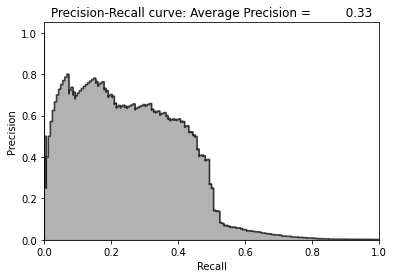

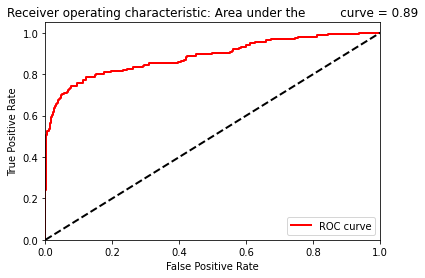

Epoch 1/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.1353 - accuracy: 0.7869 - val_loss: 0.0046 - val_accuracy: 0.9849
Epoch 2/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0511 - accuracy: 0.8483 - val_loss: 0.0045 - val_accuracy: 0.9809
Epoch 3/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0509 - accuracy: 0.8482 - val_loss: 0.0048 - val_accuracy: 0.9801
Epoch 4/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0500 - accuracy: 0.8477 - val_loss: 0.0060 - val_accuracy: 0.9764
Epoch 5/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0490 - accuracy: 0.8499 - val_loss: 0.0052 - val_accuracy: 0.9842
Epoch 6/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0487 - accuracy: 0.8474 - val_loss: 0.0040 - val_accuracy: 0.9804
Epoch 7/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0511 - accuracy: 0.8484 - val_loss: 0.0045 - val_ac

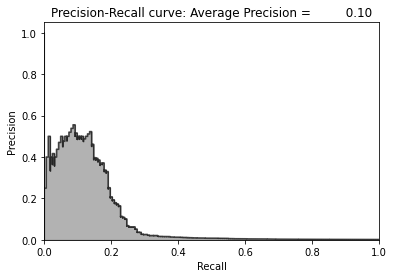

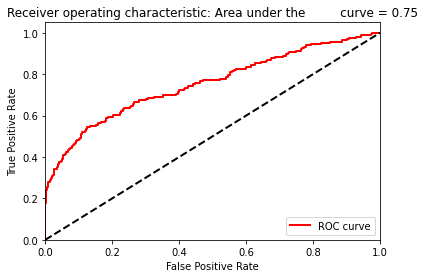

Epoch 1/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.1428 - accuracy: 0.7863 - val_loss: 0.0045 - val_accuracy: 0.9817
Epoch 2/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0502 - accuracy: 0.8478 - val_loss: 0.0044 - val_accuracy: 0.9820
Epoch 3/10
5964/5964 [==============================] - 37s 6ms/step - loss: 0.0512 - accuracy: 0.8471 - val_loss: 0.0040 - val_accuracy: 0.9845
Epoch 4/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0500 - accuracy: 0.8480 - val_loss: 0.0047 - val_accuracy: 0.9782
Epoch 5/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0501 - accuracy: 0.8477 - val_loss: 0.0042 - val_accuracy: 0.9830
Epoch 6/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0497 - accuracy: 0.8479 - val_loss: 0.0044 - val_accuracy: 0.9813
Epoch 7/10
5964/5964 [==============================] - 27s 4ms/step - loss: 0.0528 - accuracy: 0.8459 - val_loss: 0.0039 - val_ac

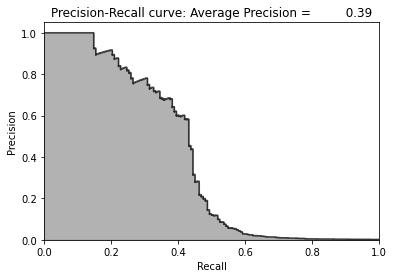

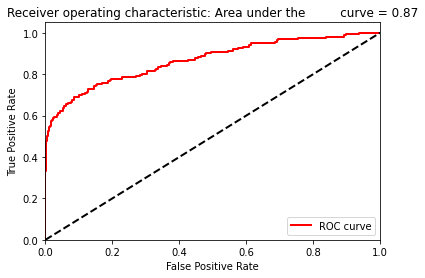

Epoch 1/10
5964/5964 [==============================] - 42s 7ms/step - loss: 0.1120 - accuracy: 0.8008 - val_loss: 0.0047 - val_accuracy: 0.9828
Epoch 2/10
5964/5964 [==============================] - 28s 5ms/step - loss: 0.0499 - accuracy: 0.8492 - val_loss: 0.0047 - val_accuracy: 0.9835
Epoch 3/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.0510 - accuracy: 0.8469 - val_loss: 0.0042 - val_accuracy: 0.9850
Epoch 4/10
5964/5964 [==============================] - 30s 5ms/step - loss: 0.0502 - accuracy: 0.8474 - val_loss: 0.0057 - val_accuracy: 0.9747
Epoch 5/10
5964/5964 [==============================] - 27s 4ms/step - loss: 0.0495 - accuracy: 0.8497 - val_loss: 0.0040 - val_accuracy: 0.9831
Epoch 6/10
5964/5964 [==============================] - 28s 5ms/step - loss: 0.0502 - accuracy: 0.8485 - val_loss: 0.0049 - val_accuracy: 0.9815
Epoch 7/10
5964/5964 [==============================] - 27s 4ms/step - loss: 0.0499 - accuracy: 0.8495 - val_loss: 0.0043 - val_ac

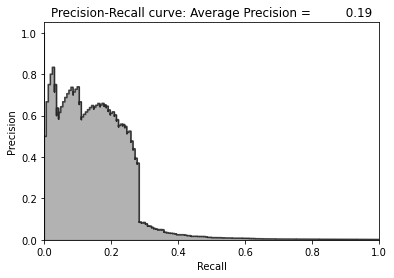

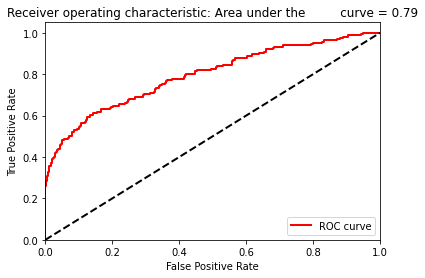

Epoch 1/10
5964/5964 [==============================] - 29s 5ms/step - loss: 0.1165 - accuracy: 0.7960 - val_loss: 0.0044 - val_accuracy: 0.9861
Epoch 2/10
5964/5964 [==============================] - 27s 4ms/step - loss: 0.0498 - accuracy: 0.8486 - val_loss: 0.0039 - val_accuracy: 0.9839
Epoch 3/10
5964/5964 [==============================] - 29s 5ms/step - loss: 0.0504 - accuracy: 0.8469 - val_loss: 0.0053 - val_accuracy: 0.9788
Epoch 4/10
5964/5964 [==============================] - 27s 4ms/step - loss: 0.0548 - accuracy: 0.8479 - val_loss: 0.0039 - val_accuracy: 0.9859
Epoch 5/10
5964/5964 [==============================] - 27s 4ms/step - loss: 0.0499 - accuracy: 0.8493 - val_loss: 0.0039 - val_accuracy: 0.9842
Epoch 6/10
5964/5964 [==============================] - 29s 5ms/step - loss: 0.0501 - accuracy: 0.8486 - val_loss: 0.0039 - val_accuracy: 0.9803
Epoch 7/10
5964/5964 [==============================] - 27s 5ms/step - loss: 0.0507 - accuracy: 0.8478 - val_loss: 0.0037 - val_ac

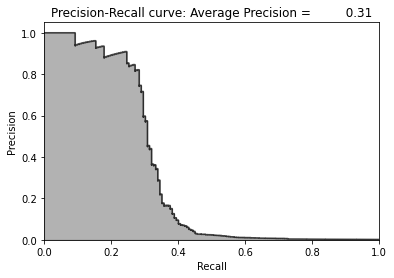

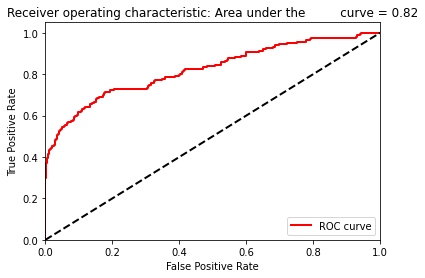

Mean average precision over 10 runs:  0.20512883132051324


[0.3007711934987836,
 0.0438184660724793,
 0.037269347373252076,
 0.1632555915054495,
 0.1786753149525796,
 0.3298042368506493,
 0.10254206077768134,
 0.39394398751559434,
 0.18832516591397216,
 0.31288294874469147]

In [ ]:
# 10번 실행 - 평균 정밀도의 평균 계산
test_scores = []

for i in range(0,10):
    # 신경망 API 호출
    model = Sequential()

    # 선형 활성화 함수 가진 40개 노드를 가진 은닉층 생성
    model.add(Dense(units=40, activation='linear',  \
        activity_regularizer=regularizers.l1(10e-5), input_dim=29))
    model.add(Dropout(0.05))

    # 29개 노드를 가진 출력층 생성
    model.add(Dense(units=29, activation='linear'))

    # 모델 컴파일
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # 모델 훈련
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE_noisy, y=X_train_AE_noisy,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # 테스트 셋에 대한 평가
    predictions = model.predict(X_test_AE_noisy, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

In [ ]:
# 결과
print("Mean average precision over 10 runs: ", np.mean(test_scores))
print("Coefficient of variation over 10 runs: ", np.std(test_scores)/ \
                                                np.mean(test_scores))
test_scores

Mean average precision over 10 runs:  0.20512883132051324
Coefficient of variation over 10 runs:  0.5756012351695352


[0.3007711934987836,
 0.0438184660724793,
 0.037269347373252076,
 0.1632555915054495,
 0.1786753149525796,
 0.3298042368506493,
 0.10254206077768134,
 0.39394398751559434,
 0.18832516591397216,
 0.31288294874469147]

평균 정밀도는 0.21이고 변동계수는 0.58입니다.

즉, 기존의 노이즈가 없는 데이터만으로 모델링한 결과 대비 낮은 성능을 보입니다.

6.12.3 ReLU 활성화 함수를 가진 2-계층 노이즈 제거 과대완전 오토인코더(은닉층 40개 노드, 희소성 정규화, 드롭아웃 비율 : 5%)

이번에는 선형 활성화 함수 대신 ReLu를 이용한 오토인코더를 실행해보겠습니다.

Epoch 1/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.2454 - accuracy: 0.6451 - val_loss: 0.0235 - val_accuracy: 0.9119
Epoch 2/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.1355 - accuracy: 0.7177 - val_loss: 0.0198 - val_accuracy: 0.9158
Epoch 3/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.1269 - accuracy: 0.7222 - val_loss: 0.0162 - val_accuracy: 0.9154
Epoch 4/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.1230 - accuracy: 0.7251 - val_loss: 0.0215 - val_accuracy: 0.9088
Epoch 5/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.1196 - accuracy: 0.7300 - val_loss: 0.0136 - val_accuracy: 0.9261
Epoch 6/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.1171 - accuracy: 0.7311 - val_loss: 0.0133 - val_accuracy: 0.9184
Epoch 7/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.1156 - accuracy: 0.7343 - val_loss: 0.0122 - val_ac

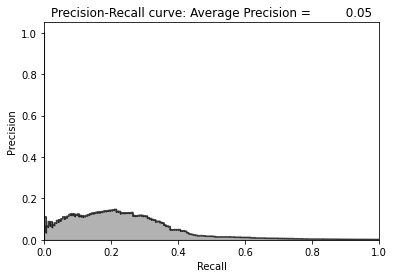

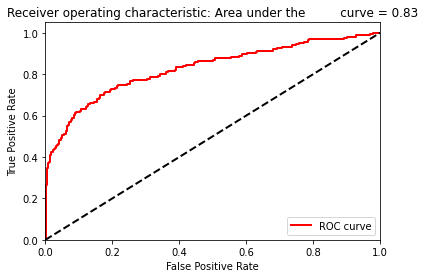

Epoch 1/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.2130 - accuracy: 0.6648 - val_loss: 0.0219 - val_accuracy: 0.9131
Epoch 2/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.1298 - accuracy: 0.7239 - val_loss: 0.0158 - val_accuracy: 0.9217
Epoch 3/10
5964/5964 [==============================] - 27s 5ms/step - loss: 0.1220 - accuracy: 0.7268 - val_loss: 0.0136 - val_accuracy: 0.9207
Epoch 4/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.1178 - accuracy: 0.7312 - val_loss: 0.0132 - val_accuracy: 0.9200
Epoch 5/10
5964/5964 [==============================] - 36s 6ms/step - loss: 0.1162 - accuracy: 0.7343 - val_loss: 0.0128 - val_accuracy: 0.9263
Epoch 6/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.1167 - accuracy: 0.7352 - val_loss: 0.0132 - val_accuracy: 0.9169
Epoch 7/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.1154 - accuracy: 0.7385 - val_loss: 0.0125 - val_ac

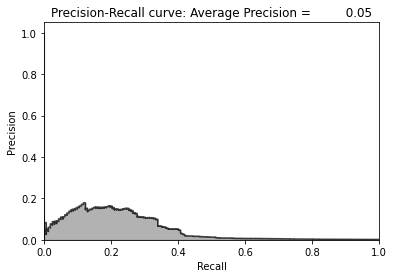

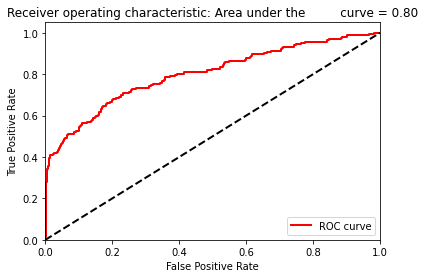

Epoch 1/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.2885 - accuracy: 0.6215 - val_loss: 0.0223 - val_accuracy: 0.9107
Epoch 2/10
5964/5964 [==============================] - 27s 5ms/step - loss: 0.1352 - accuracy: 0.7189 - val_loss: 0.0176 - val_accuracy: 0.9228
Epoch 3/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.1266 - accuracy: 0.7263 - val_loss: 0.0183 - val_accuracy: 0.9184
Epoch 4/10
5964/5964 [==============================] - 28s 5ms/step - loss: 0.1216 - accuracy: 0.7317 - val_loss: 0.0140 - val_accuracy: 0.9282
Epoch 5/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.1184 - accuracy: 0.7350 - val_loss: 0.0137 - val_accuracy: 0.9267
Epoch 6/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.1149 - accuracy: 0.7361 - val_loss: 0.0128 - val_accuracy: 0.9308
Epoch 7/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.1138 - accuracy: 0.7394 - val_loss: 0.0129 - val_ac

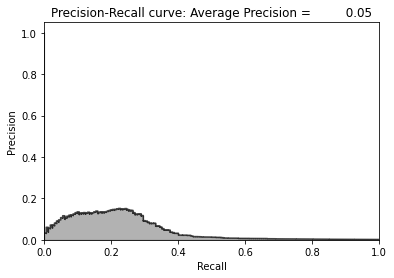

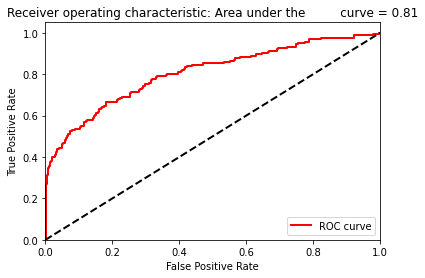

Epoch 1/10
5964/5964 [==============================] - 27s 4ms/step - loss: 0.2261 - accuracy: 0.6587 - val_loss: 0.0230 - val_accuracy: 0.9115
Epoch 2/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.1321 - accuracy: 0.7221 - val_loss: 0.0192 - val_accuracy: 0.9125
Epoch 3/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.1248 - accuracy: 0.7304 - val_loss: 0.0150 - val_accuracy: 0.9209
Epoch 4/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.1191 - accuracy: 0.7340 - val_loss: 0.0141 - val_accuracy: 0.9246
Epoch 5/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.1178 - accuracy: 0.7353 - val_loss: 0.0134 - val_accuracy: 0.9334
Epoch 6/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.1168 - accuracy: 0.7368 - val_loss: 0.0129 - val_accuracy: 0.9317
Epoch 7/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.1173 - accuracy: 0.7383 - val_loss: 0.0127 - val_ac

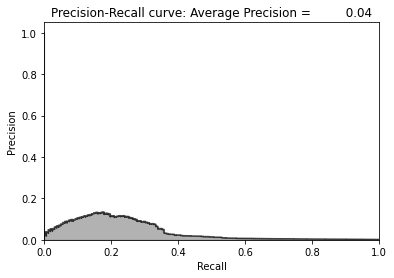

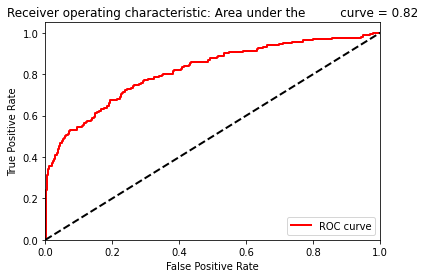

Epoch 1/10
5964/5964 [==============================] - 27s 5ms/step - loss: 0.2211 - accuracy: 0.6560 - val_loss: 0.0204 - val_accuracy: 0.9195
Epoch 2/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.1297 - accuracy: 0.7246 - val_loss: 0.0177 - val_accuracy: 0.9163
Epoch 3/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.1242 - accuracy: 0.7300 - val_loss: 0.0146 - val_accuracy: 0.9211
Epoch 4/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.1200 - accuracy: 0.7315 - val_loss: 0.0135 - val_accuracy: 0.9250
Epoch 5/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.1171 - accuracy: 0.7350 - val_loss: 0.0141 - val_accuracy: 0.9218
Epoch 6/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.1148 - accuracy: 0.7355 - val_loss: 0.0131 - val_accuracy: 0.9178
Epoch 7/10
5964/5964 [==============================] - 27s 4ms/step - loss: 0.1148 - accuracy: 0.7353 - val_loss: 0.0127 - val_ac

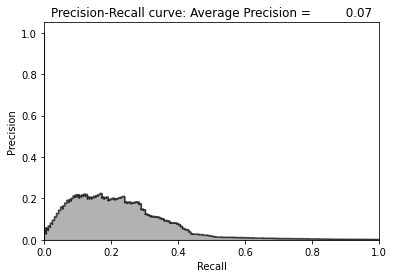

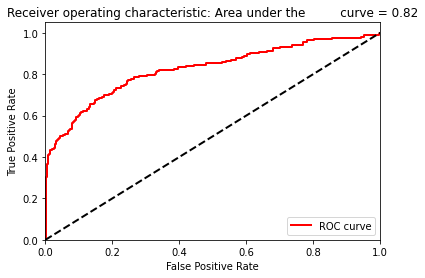

Epoch 1/10
5964/5964 [==============================] - 27s 4ms/step - loss: 0.2255 - accuracy: 0.6529 - val_loss: 0.0239 - val_accuracy: 0.8958
Epoch 2/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.1310 - accuracy: 0.7211 - val_loss: 0.0195 - val_accuracy: 0.9102
Epoch 3/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.1236 - accuracy: 0.7309 - val_loss: 0.0153 - val_accuracy: 0.9272
Epoch 4/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.1193 - accuracy: 0.7371 - val_loss: 0.0146 - val_accuracy: 0.9146
Epoch 5/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.1183 - accuracy: 0.7374 - val_loss: 0.0137 - val_accuracy: 0.9185
Epoch 6/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.1160 - accuracy: 0.7399 - val_loss: 0.0132 - val_accuracy: 0.9268
Epoch 7/10
5964/5964 [==============================] - 27s 4ms/step - loss: 0.1130 - accuracy: 0.7411 - val_loss: 0.0121 - val_ac

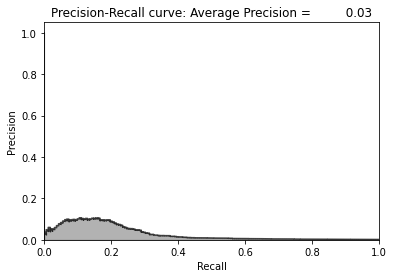

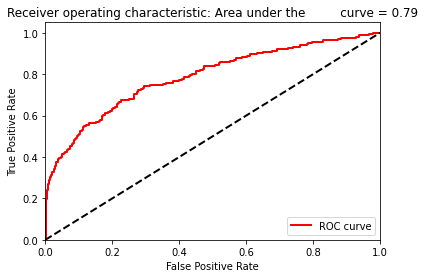

Epoch 1/10
5964/5964 [==============================] - 27s 5ms/step - loss: 0.2351 - accuracy: 0.6527 - val_loss: 0.0225 - val_accuracy: 0.9155
Epoch 2/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.1329 - accuracy: 0.7209 - val_loss: 0.0193 - val_accuracy: 0.9059
Epoch 3/10
5964/5964 [==============================] - 27s 4ms/step - loss: 0.1253 - accuracy: 0.7265 - val_loss: 0.0163 - val_accuracy: 0.9194
Epoch 4/10
5964/5964 [==============================] - 27s 4ms/step - loss: 0.1192 - accuracy: 0.7322 - val_loss: 0.0148 - val_accuracy: 0.9208
Epoch 5/10
5964/5964 [==============================] - 27s 5ms/step - loss: 0.1157 - accuracy: 0.7352 - val_loss: 0.0130 - val_accuracy: 0.9288
Epoch 6/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.1143 - accuracy: 0.7364 - val_loss: 0.0124 - val_accuracy: 0.9309
Epoch 7/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.1165 - accuracy: 0.7379 - val_loss: 0.0140 - val_ac

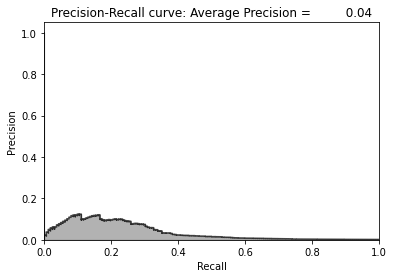

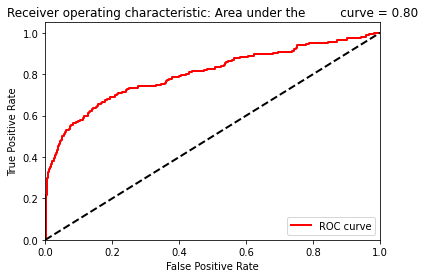

Epoch 1/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.2350 - accuracy: 0.6562 - val_loss: 0.0221 - val_accuracy: 0.9222
Epoch 2/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.1336 - accuracy: 0.7213 - val_loss: 0.0171 - val_accuracy: 0.9283
Epoch 3/10
5964/5964 [==============================] - 27s 5ms/step - loss: 0.1248 - accuracy: 0.7269 - val_loss: 0.0176 - val_accuracy: 0.9071
Epoch 4/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.1207 - accuracy: 0.7318 - val_loss: 0.0138 - val_accuracy: 0.9310
Epoch 5/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.1175 - accuracy: 0.7337 - val_loss: 0.0144 - val_accuracy: 0.9225
Epoch 6/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.1156 - accuracy: 0.7365 - val_loss: 0.0133 - val_accuracy: 0.9239
Epoch 7/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.1135 - accuracy: 0.7393 - val_loss: 0.0122 - val_ac

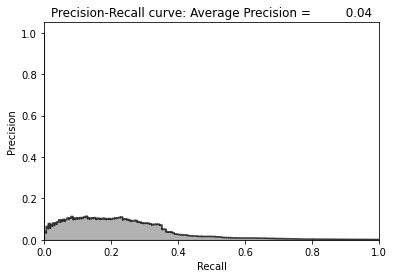

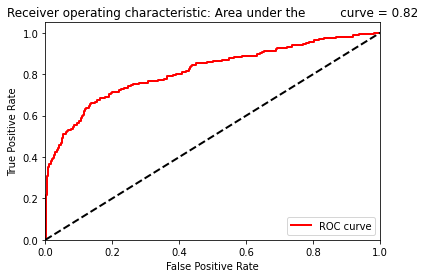

Epoch 1/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.2275 - accuracy: 0.6502 - val_loss: 0.0228 - val_accuracy: 0.9052
Epoch 2/10
5964/5964 [==============================] - 27s 4ms/step - loss: 0.1325 - accuracy: 0.7199 - val_loss: 0.0172 - val_accuracy: 0.9158
Epoch 3/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.1253 - accuracy: 0.7256 - val_loss: 0.0182 - val_accuracy: 0.8966
Epoch 4/10
5964/5964 [==============================] - 27s 4ms/step - loss: 0.1210 - accuracy: 0.7293 - val_loss: 0.0137 - val_accuracy: 0.9214
Epoch 5/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.1169 - accuracy: 0.7336 - val_loss: 0.0133 - val_accuracy: 0.9188
Epoch 6/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.1143 - accuracy: 0.7348 - val_loss: 0.0123 - val_accuracy: 0.9221
Epoch 7/10
5964/5964 [==============================] - 27s 4ms/step - loss: 0.1112 - accuracy: 0.7375 - val_loss: 0.0127 - val_ac

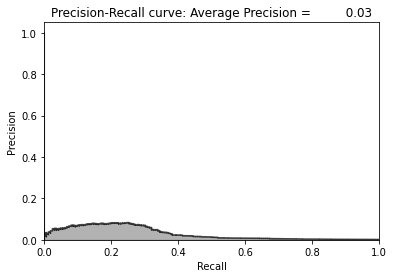

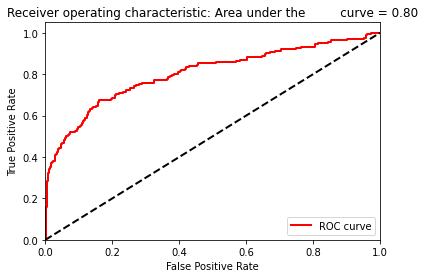

Epoch 1/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.2447 - accuracy: 0.6487 - val_loss: 0.0219 - val_accuracy: 0.9162
Epoch 2/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.1306 - accuracy: 0.7243 - val_loss: 0.0159 - val_accuracy: 0.9274
Epoch 3/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.1232 - accuracy: 0.7293 - val_loss: 0.0151 - val_accuracy: 0.9238
Epoch 4/10
5964/5964 [==============================] - 26s 4ms/step - loss: 0.1186 - accuracy: 0.7329 - val_loss: 0.0135 - val_accuracy: 0.9335
Epoch 5/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.1178 - accuracy: 0.7328 - val_loss: 0.0133 - val_accuracy: 0.9270
Epoch 6/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.1159 - accuracy: 0.7369 - val_loss: 0.0127 - val_accuracy: 0.9313
Epoch 7/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.1129 - accuracy: 0.7376 - val_loss: 0.0128 - val_ac

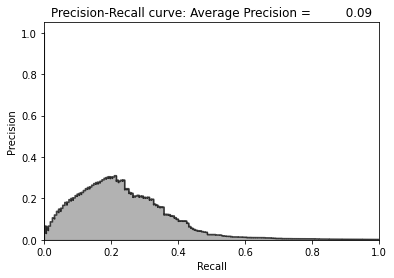

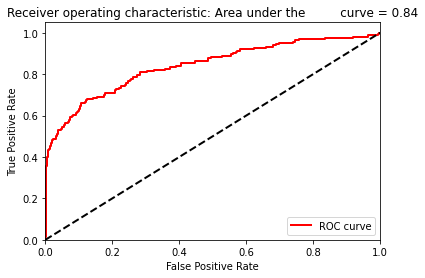

Mean average precision over 10 runs:  0.04868385404285619


[0.05019332408247047,
 0.05243087724191465,
 0.046934573427232694,
 0.03980453460502831,
 0.07079900779890687,
 0.02920660519356679,
 0.036778559327590415,
 0.039963281715888324,
 0.02954329384023195,
 0.09118448319573141]

In [ ]:
# 10번 실행 - 평균 정밀도의 평균 계산
test_scores = []

noise_factor = 0.50
X_train_AE_noisy = X_train_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_train_AE.shape)
X_test_AE_noisy = X_test_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_test_AE.shape) 
    
for i in range(0,10):
    # 신경망 API 호출
    model = Sequential()

    # 선형 활성화 함수를 가진 40개 노드를 가진 은닉층 생성
    model.add(Dense(units=40, activation='relu',  \
        activity_regularizer=regularizers.l1(10e-5), input_dim=29))
    model.add(Dropout(0.05))

    # 29개 노드를 가진 출력층 생성
    model.add(Dense(units=29, activation='linear'))

    # 모델 컴파일
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # 모델 훈련
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE_noisy, y=X_train_AE_noisy,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # 테스트 셋에 대한 평가
    predictions = model.predict(X_test_AE_noisy, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

In [ ]:
# 결과
print("Mean average precision over 10 runs: ", np.mean(test_scores))
print("Coefficient of variation over 10 runs: ", np.std(test_scores)/ \
                                                np.mean(test_scores))
test_scores

Mean average precision over 10 runs:  0.04868385404285619
Coefficient of variation over 10 runs:  0.3763553027210481


[0.05019332408247047,
 0.05243087724191465,
 0.046934573427232694,
 0.03980453460502831,
 0.07079900779890687,
 0.02920660519356679,
 0.036778559327590415,
 0.039963281715888324,
 0.02954329384023195,
 0.09118448319573141]

평균 정밀도는 0.05이고 변동계수는 0.37입니다.

이 모델 또한, 기존의 노이즈가 없는 데이터만으로 모델링한 결과 대비 낮은 성능을 보이며 선형 활성화 함수보다도 낮은 성능을 보입니다.

오토 인코더를 위한 최적 아키텍처를 찾기위해 여러 모델링을 진행해보았습니다.
단일, 여러개의 은닉층을 사용해보고 과소완전, 과대완전 오토인코더 그리고 선형 및 비선형 활성화 함수 사용, 마지막으로 희소 및 드롭아웃을 적용해보았습니다.

결과적으로 선형 활성화 함수로 구성된 단순한 2-계층 과소완전 신경망이 가장 잘 작동하는 것을 알 수 있었습니다.

또한, 노이즈를 잘 제거하기 위해서도 여러 모델링을 진행해보았습니다.

더 나은 오토인코더 모델을 찾기 위해서는 이처럼 다양한 실험이 필요합니다.